In [1]:
import eli5
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestClassifier
from eli5.sklearn import PermutationImportance
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns


import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader

import warnings
warnings.filterwarnings("ignore")

In [2]:
def preprocessing(X_train, X_test):
    
    scaler = StandardScaler()
    
    scaler.fit(X_train) 
    
    X_train = scaler.transform(X_train)

    X_test = scaler.transform(X_test)  
    
    return X_train, X_test

In [3]:
def display_correlation_matrix(data):
    
    corr_matrix = data.corr()
    
    display(corr_matrix)

    mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))

    f, ax = plt.subplots(figsize=(11, 9))

    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [4]:
def drop_highly_correlated_features(data, threshold = 0.99):

    corr_matrix = data.corr().abs()

    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    print("Features to drop for Threshold " + str(threshold), to_drop)
    
    data.drop(data[to_drop], axis = 1, inplace = True)
    
    return data

In [5]:
def display_feature_importance(model, features, labels):
    print("Features: ", features.columns.values)
    importance = PermutationImportance(model).fit(features, y_test)
    return importance

In [6]:
class HousePriceDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__ (self, index):
        x = self.features[index]
        y = self.labels[index]
        
        return x, y

In [7]:
class NeuralNetwork(nn.Module):
    
    def __init__(self, m_hidden_layers, n_input, n_hidden, n_output, network_type = "classification"):
        super().__init__()
        
        self.m_hidden_layers = m_hidden_layers
        
        self.input_layer = nn.Linear(n_input, n_hidden)
    
        self.hidden_layer = nn.Linear(n_hidden, n_hidden)
        
        self.output_layer = nn.Linear(n_hidden, n_output)
        
        self.bn  = nn.BatchNorm1d(n_hidden)
        
        self.activation = nn.LeakyReLU()
        
        assert network_type in ["classification", "regression"]
        
        self.network_type = network_type
        
        self.dropout = nn.Dropout(p = 0.2)
        
    def forward(self, x):
        
        # Use dropout only for regression
        
        if self.network_type == "regression":
            
            x = self.dropout(self.activation(self.input_layer(x)))

            for step in range(self.m_hidden_layers):
                x = self.dropout(self.activation(self.bn(self.hidden_layer(x))))

            x = self.output_layer(x)
        
        else:
            
            x = self.activation(self.input_layer(x))

            for step in range(self.m_hidden_layers):
                x = self.activation(self.bn(self.hidden_layer(x)))

            x = self.output_layer(x)
        
        return x

In [8]:
from scipy.optimize import minimize
from functools import partial

class OptimizedRounder(object):
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    def __init__(self):
        self.coef = 0

    def loss(self, coef, samples, labels):
        """
        Get loss according to
        using current coefficients
        
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        
        
        limit = [-np.inf] + list(np.sort(coef)) + [np.inf]

        opt_labels = pd.cut(samples, limit, labels = [0, 1, 2, 3, 4])

        return -accuracy_score(opt_labels, labels) 


    
    def fit(self, X, y):
        """
        Optimize rounding thresholds
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self.loss, samples = X, labels=y)
        
        initial_coef = [1, 2, 3, 4]

        self.coef = minimize(loss_partial, initial_coef, method='Nelder-Mead')
        


    def predict(self, X):
        """
        Make predictions with specified thresholds
        
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        
        limit = [-np.inf] + list(np.sort(self.coef['x'])) + [np.inf]

        return pd.cut(X, limit, labels = [0, 1, 2, 3, 4])
    
    def coefficients(self):
        return self.coef['x']

In [9]:
def RMSLELoss(y_true, y_hat):
    return torch.abs(torch.sqrt(torch.mean((torch.log(y_true + 1) - torch.log(y_hat.float() + 1)) ** 2)))

In [10]:
def RMSLELoss_for_numpy(h, y): 
    """
    Compute the Root Mean Squared Log Error for hypthesis h and targets y
    
    Args:
        h - numpy array containing predictions with shape (n_samples, n_targets)
        y - numpy array containing targets with shape (n_samples, n_targets)
    """
    return np.sqrt(np.square(np.log(h + 1) - np.log(y + 1)).mean())

# Reading the dataset
- Will separate the labels from features
- And will map the labels from (1 - 5) to (0 - 4) for convenience in the softmax layer

In [11]:
data = pd.read_csv("Bucharest_HousePriceDataset.csv")

display(data.head(n = 10))

features = data.drop(['Scor'], axis = 1, inplace = False)

labels   = data["Scor"].apply(lambda x : x - 1)

,Nr Camere,Suprafata,Etaj,Total Etaje,Sector,Scor,Pret
0,4,108.00,2,3,4,5,83000
1,1,41.00,1,8,1,1,39900
2,3,63.52,1,3,2,3,84900
3,1,33.00,3,10,5,1,45500
4,2,62.00,5,9,5,5,54900
5,3,132.00,2,6,1,2,349990
6,2,49.00,6,6,6,4,36500
7,3,92.00,4,8,2,2,119000
8,3,68.00,3,5,4,5,67500
9,3,110.00,1,2,1,1,133000


# Visualize the correlation matrix 
- Drop higgly correlated features (if necessary)


,Nr Camere,Suprafata,Etaj,Total Etaje,Sector,Scor,Pret
Nr Camere,1.000000,0.807278,0.066427,-0.012815,-0.183737,-0.215591,0.635789
Suprafata,0.807278,1.000000,0.060527,-0.041367,-0.240274,-0.299838,0.807414
Etaj,0.066427,0.060527,1.000000,0.559217,0.061581,0.027381,0.038719
Total Etaje,-0.012815,-0.041367,0.559217,1.000000,0.103467,0.036039,0.006063
Sector,-0.183737,-0.240274,0.061581,0.103467,1.000000,0.577602,-0.409052
Scor,-0.215591,-0.299838,0.027381,0.036039,0.577602,1.000000,-0.531826
Pret,0.635789,0.807414,0.038719,0.006063,-0.409052,-0.531826,1.000000


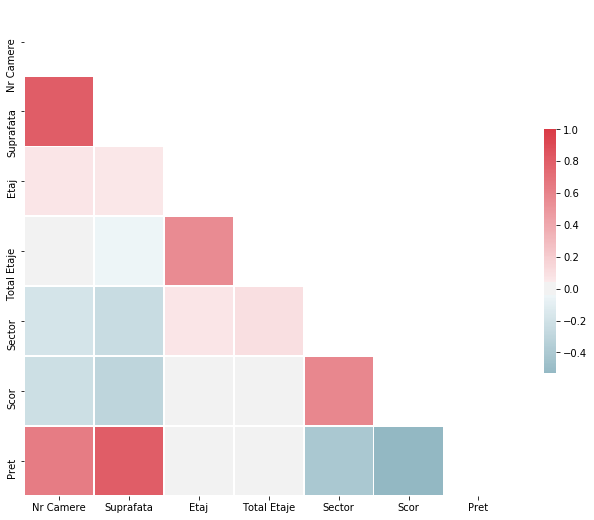

In [12]:
display_correlation_matrix(data)

In [13]:
data = drop_highly_correlated_features(data)

Features to drop for Threshold 0.99 []


# Splitting Data Methodology
- First step: Will get a hold out set (train set - test set: 0.8 - 0.2)
- Second step: Will use a cross-validation with 5 fold (4 training fold - 1 validation fold)

- As note: This Methodology is typically used in deep learning for large datasets, this concludes that for our 3529 samples may not be fitted


In [14]:
X_train, X_test, y_train, y_test = train_test_split(features, labels.values, train_size = 0.9, random_state = 42)

# Lets get a baseline model without cross-validation

- To get a sense of the problem will display the accuracy and the feature importance of the model



In [15]:
model = RandomForestClassifier(n_estimators = 100)

model.fit(X_train, y_train)

y_predict = model.predict(X_test)

accuracy = accuracy_score(y_predict, y_test)

print("Baseline Random Forest: ", accuracy)

importance = display_feature_importance(model, X_test, y_test)

eli5.show_weights(importance)

Baseline Random Forest:  0.7932011331444759
Features:  ['Nr Camere' 'Suprafata' 'Etaj' 'Total Etaje' 'Sector' 'Pret']


Weight,Feature
0.4414 ± 0.0576,x4
0.2765 ± 0.0508,x5
0.0657 ± 0.0458,x3
0.0584 ± 0.0292,x1
0.0323 ± 0.0205,x2
0.0221 ± 0.0225,x0



# Lets do the same for a neural network from sklearn

In [16]:
model = MLPClassifier(hidden_layer_sizes = (10, 10, 10, 10))

model.fit(X_train, y_train)

y_predict = model.predict(X_test)

accuracy = accuracy_score(y_predict, y_test)

print("Baseline Neural Network: ", accuracy)

Baseline Neural Network:  0.2096317280453258





# Something went wrong...
- As you can see the results are quite disappointing, and the reason for this difference in each model accuracy is that tree base models (such as Random Forrest) are invariant to features scaling, but the neural networks are not

# Lets use a mean normalization over data and retry the experiment 

In [17]:
X_train_scaled, X_test_scaled = preprocessing(X_train, X_test)
print(len(X_train_scaled))
print(len(X_test_scaled))

3176
353


In [18]:
model = MLPClassifier(hidden_layer_sizes = (12, 12, 12, 12, 12), max_iter = 500)

model.fit(X_train_scaled, y_train)

y_predict = model.predict(X_test_scaled)

accuracy = accuracy_score(y_predict, y_test)

print("Baseline Neural Network: ", accuracy)

Baseline Neural Network:  0.7592067988668555


# That's much better, now lets do that in Pytorch
- But now with cross-validation 

Model for Fold: 0
Epoch: 1/100..  Training Loss: 1.244..  Test Loss: 1.098..  Test Accuracy: 0.520
Epoch: 2/100..  Training Loss: 0.997..  Test Loss: 0.799..  Test Accuracy: 0.653
Epoch: 3/100..  Training Loss: 0.809..  Test Loss: 0.673..  Test Accuracy: 0.728
Epoch: 4/100..  Training Loss: 0.780..  Test Loss: 0.643..  Test Accuracy: 0.743
Epoch: 5/100..  Training Loss: 0.758..  Test Loss: 0.640..  Test Accuracy: 0.721
Epoch: 6/100..  Training Loss: 0.717..  Test Loss: 0.639..  Test Accuracy: 0.701
Epoch: 7/100..  Training Loss: 0.688..  Test Loss: 0.650..  Test Accuracy: 0.701
Epoch: 8/100..  Training Loss: 0.707..  Test Loss: 0.586..  Test Accuracy: 0.743
Epoch: 9/100..  Training Loss: 0.700..  Test Loss: 0.598..  Test Accuracy: 0.718
Epoch: 10/100..  Training Loss: 0.677..  Test Loss: 0.623..  Test Accuracy: 0.711
Epoch: 11/100..  Training Loss: 0.670..  Test Loss: 0.579..  Test Accuracy: 0.748
Epoch: 12/100..  Training Loss: 0.667..  Test Loss: 0.560..  Test Accuracy: 0.740
Epoch: 

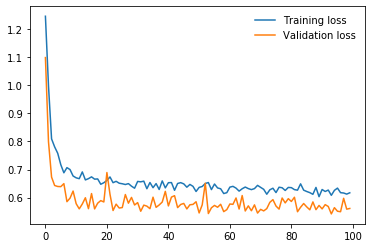

Model for Fold: 1
Epoch: 1/100..  Training Loss: 1.219..  Test Loss: 0.997..  Test Accuracy: 0.590
Epoch: 2/100..  Training Loss: 0.997..  Test Loss: 0.804..  Test Accuracy: 0.688
Epoch: 3/100..  Training Loss: 0.850..  Test Loss: 0.679..  Test Accuracy: 0.711
Epoch: 4/100..  Training Loss: 0.780..  Test Loss: 0.667..  Test Accuracy: 0.693
Epoch: 5/100..  Training Loss: 0.745..  Test Loss: 0.647..  Test Accuracy: 0.722
Epoch: 6/100..  Training Loss: 0.714..  Test Loss: 0.631..  Test Accuracy: 0.743
Epoch: 7/100..  Training Loss: 0.710..  Test Loss: 0.608..  Test Accuracy: 0.714
Epoch: 8/100..  Training Loss: 0.708..  Test Loss: 0.618..  Test Accuracy: 0.734
Epoch: 9/100..  Training Loss: 0.703..  Test Loss: 0.622..  Test Accuracy: 0.727
Epoch: 10/100..  Training Loss: 0.695..  Test Loss: 0.594..  Test Accuracy: 0.718
Epoch: 11/100..  Training Loss: 0.691..  Test Loss: 0.630..  Test Accuracy: 0.726
Epoch: 12/100..  Training Loss: 0.698..  Test Loss: 0.622..  Test Accuracy: 0.738
Epoch: 

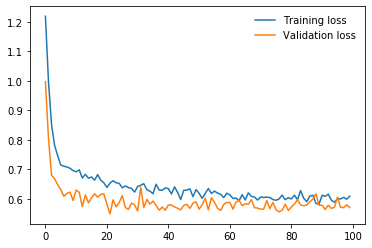

Model for Fold: 2
Epoch: 1/100..  Training Loss: 1.186..  Test Loss: 1.071..  Test Accuracy: 0.558
Epoch: 2/100..  Training Loss: 0.923..  Test Loss: 0.862..  Test Accuracy: 0.666
Epoch: 3/100..  Training Loss: 0.809..  Test Loss: 0.707..  Test Accuracy: 0.719
Epoch: 4/100..  Training Loss: 0.728..  Test Loss: 0.747..  Test Accuracy: 0.656
Epoch: 5/100..  Training Loss: 0.736..  Test Loss: 0.764..  Test Accuracy: 0.665
Epoch: 6/100..  Training Loss: 0.695..  Test Loss: 0.658..  Test Accuracy: 0.729
Epoch: 7/100..  Training Loss: 0.700..  Test Loss: 0.679..  Test Accuracy: 0.712
Epoch: 8/100..  Training Loss: 0.698..  Test Loss: 0.665..  Test Accuracy: 0.712
Epoch: 9/100..  Training Loss: 0.686..  Test Loss: 0.629..  Test Accuracy: 0.737
Epoch: 10/100..  Training Loss: 0.676..  Test Loss: 0.643..  Test Accuracy: 0.731
Epoch: 11/100..  Training Loss: 0.663..  Test Loss: 0.628..  Test Accuracy: 0.726
Epoch: 12/100..  Training Loss: 0.686..  Test Loss: 0.665..  Test Accuracy: 0.716
Epoch: 

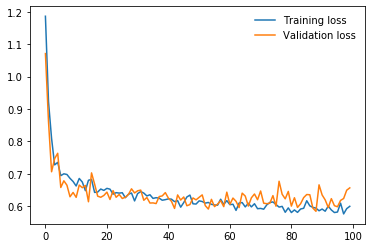

Model for Fold: 3
Epoch: 1/100..  Training Loss: 1.158..  Test Loss: 0.980..  Test Accuracy: 0.531
Epoch: 2/100..  Training Loss: 0.937..  Test Loss: 0.818..  Test Accuracy: 0.634
Epoch: 3/100..  Training Loss: 0.834..  Test Loss: 0.679..  Test Accuracy: 0.708
Epoch: 4/100..  Training Loss: 0.778..  Test Loss: 0.654..  Test Accuracy: 0.733
Epoch: 5/100..  Training Loss: 0.725..  Test Loss: 0.642..  Test Accuracy: 0.726
Epoch: 6/100..  Training Loss: 0.716..  Test Loss: 0.648..  Test Accuracy: 0.738
Epoch: 7/100..  Training Loss: 0.735..  Test Loss: 0.643..  Test Accuracy: 0.728
Epoch: 8/100..  Training Loss: 0.711..  Test Loss: 0.630..  Test Accuracy: 0.725
Epoch: 9/100..  Training Loss: 0.688..  Test Loss: 0.679..  Test Accuracy: 0.696
Epoch: 10/100..  Training Loss: 0.716..  Test Loss: 0.641..  Test Accuracy: 0.735
Epoch: 11/100..  Training Loss: 0.725..  Test Loss: 0.639..  Test Accuracy: 0.732
Epoch: 12/100..  Training Loss: 0.688..  Test Loss: 0.693..  Test Accuracy: 0.704
Epoch: 

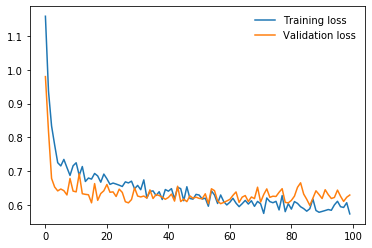

Model for Fold: 4
Epoch: 1/100..  Training Loss: 1.129..  Test Loss: 0.970..  Test Accuracy: 0.568
Epoch: 2/100..  Training Loss: 0.899..  Test Loss: 0.757..  Test Accuracy: 0.699
Epoch: 3/100..  Training Loss: 0.810..  Test Loss: 0.715..  Test Accuracy: 0.691
Epoch: 4/100..  Training Loss: 0.804..  Test Loss: 0.683..  Test Accuracy: 0.701
Epoch: 5/100..  Training Loss: 0.761..  Test Loss: 0.627..  Test Accuracy: 0.718
Epoch: 6/100..  Training Loss: 0.742..  Test Loss: 0.607..  Test Accuracy: 0.734
Epoch: 7/100..  Training Loss: 0.758..  Test Loss: 0.659..  Test Accuracy: 0.693
Epoch: 8/100..  Training Loss: 0.720..  Test Loss: 0.616..  Test Accuracy: 0.723
Epoch: 9/100..  Training Loss: 0.693..  Test Loss: 0.661..  Test Accuracy: 0.714
Epoch: 10/100..  Training Loss: 0.697..  Test Loss: 0.642..  Test Accuracy: 0.709
Epoch: 11/100..  Training Loss: 0.710..  Test Loss: 0.646..  Test Accuracy: 0.701
Epoch: 12/100..  Training Loss: 0.712..  Test Loss: 0.613..  Test Accuracy: 0.725
Epoch: 

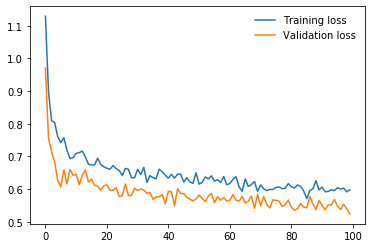

In [19]:
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
cv = cv.split(X_train_scaled, y_train)

m_hidden_layers = 1
n_input = 6
n_hidden = 12
n_output = 5
network_type = "classification"

bs = 16

device = "cuda:0"

models = []
max_scores = []
for fold, (train_idx, val_idx) in enumerate(cv):
    print("Model for Fold: " + str(fold))

    train_set, train_labels = X_train_scaled[train_idx], y_train[train_idx]
    valid_set, valid_labels = X_train_scaled[val_idx], y_train[val_idx]
    
    trainset = HousePriceDataset(train_set, train_labels)
    trainloader = DataLoader(trainset, batch_size = bs, shuffle = True)

    validset = HousePriceDataset(valid_set, valid_labels)
    validloader = DataLoader(validset, batch_size = bs, shuffle = True)
    
    model = NeuralNetwork(m_hidden_layers, n_input, n_hidden, n_output, network_type).to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.02)

    epochs = 100
    
    train_losses, test_losses = [], []
    
    best_accuracy = 0
    best_model_checkpoint = None
    
    for e in range(epochs):
        running_loss = 0

    
        for features, labels in trainloader:
            model.train()
            features = features.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()

            log_ps = model(features.float())

            loss = criterion(log_ps, labels)
        
            loss.backward()

            optimizer.step()

            running_loss += loss.item()

        else:
            test_loss = 0
            accuracy = 0

            
            with torch.no_grad():
                for features, labels in validloader:
                    
                    model.eval()
                    features = features.to(device)
                    labels = labels.to(device)

                    log_ps = model(features.float())

                    test_loss += criterion(log_ps, labels)

                    top_p, top_class = log_ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor))
                    
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(validloader))
            
            if (accuracy / len(validloader)) > best_accuracy:
                best_accuracy = accuracy/len(validloader)
                best_model_checkpoint = model
            
            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(validloader)),
                  "Test Accuracy: {:.3f}".format(accuracy/len(validloader)))
            
    plt.plot(train_losses, label='Training loss')
    plt.plot(test_losses, label='Validation loss')
    plt.legend(frameon=False)
    plt.show()

    models.append(best_model_checkpoint)
    max_scores.append(best_accuracy)

In [20]:
index = 0
for score in max_scores:
    print("Fold: {}, with score: {:.3f}" .format(index, score.item()))
    index += 1

Fold: 0, with score: 0.776
Fold: 1, with score: 0.754
Fold: 2, with score: 0.759
Fold: 3, with score: 0.755
Fold: 4, with score: 0.756


In [21]:
evalset = HousePriceDataset(X_test_scaled, y_test)
loader  = DataLoader(evalset, batch_size=len(X_test_scaled))

with torch.no_grad():
    for features, labels in loader: 
        features = features.to(device)
        labels = labels.to(device)
        
        logs = 0
        index = 0
        for model in models:
            model.eval()
            log_ps = model(features.float())
            logs += (log_ps * max_scores[index]) / sum(max_scores)
            index += 1
        
        logs = logs / len(models)
        
        ps = torch.exp(logs)
            
        _, indices = torch.max(ps, dim = 1)
        
y_predict = indices.cpu().numpy()
print("Final Model Testing Score: " + str(accuracy_score(y_predict, y_test)))

Final Model Testing Score: 0.7337110481586402


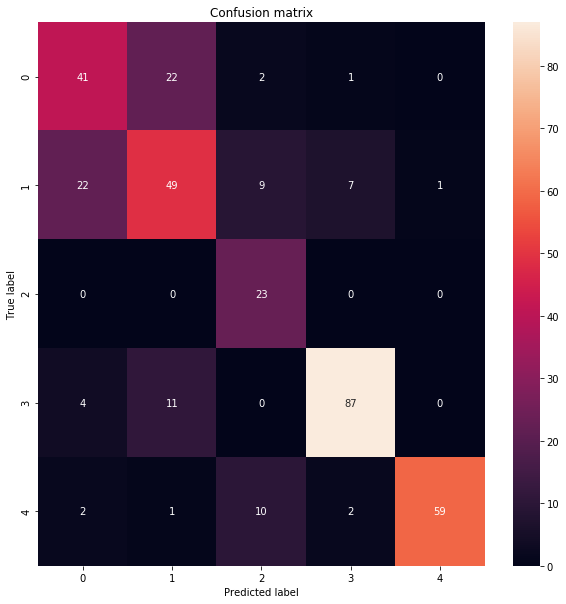

In [22]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_predict)
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

# Regression Part 
- The differences will be: 
1. The loss function: Mean Squared Error
2. Number of neurons in the final layer will one (a continuous value)
3. Will need to find some optim thresholds to map that continuous value in the discrete labels

Model for Fold: 0
Epoch: 1/100..  Training Loss: 8.904..  Test Loss: 8.117.. 
Epoch: 2/100..  Training Loss: 8.225..  Test Loss: 7.681.. 
Epoch: 3/100..  Training Loss: 7.618..  Test Loss: 7.253.. 
Epoch: 4/100..  Training Loss: 7.153..  Test Loss: 6.855.. 
Epoch: 5/100..  Training Loss: 6.746..  Test Loss: 6.517.. 
Epoch: 6/100..  Training Loss: 6.436..  Test Loss: 6.176.. 
Epoch: 7/100..  Training Loss: 6.122..  Test Loss: 5.866.. 
Epoch: 8/100..  Training Loss: 5.772..  Test Loss: 5.555.. 
Epoch: 9/100..  Training Loss: 5.476..  Test Loss: 5.171.. 
Epoch: 10/100..  Training Loss: 5.132..  Test Loss: 4.970.. 
Epoch: 11/100..  Training Loss: 4.938..  Test Loss: 4.764.. 
Epoch: 12/100..  Training Loss: 4.754..  Test Loss: 4.663.. 
Epoch: 13/100..  Training Loss: 4.470..  Test Loss: 4.511.. 
Epoch: 14/100..  Training Loss: 4.313..  Test Loss: 4.100.. 
Epoch: 15/100..  Training Loss: 4.073..  Test Loss: 3.931.. 
Epoch: 16/100..  Training Loss: 3.851..  Test Loss: 3.626.. 
Epoch: 17/100..

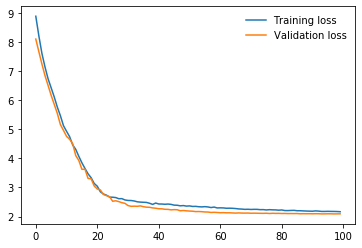

Model for Fold: 1
Epoch: 1/100..  Training Loss: 9.569..  Test Loss: 8.788.. 
Epoch: 2/100..  Training Loss: 8.861..  Test Loss: 8.536.. 
Epoch: 3/100..  Training Loss: 8.263..  Test Loss: 8.074.. 
Epoch: 4/100..  Training Loss: 7.719..  Test Loss: 7.602.. 
Epoch: 5/100..  Training Loss: 7.160..  Test Loss: 7.056.. 
Epoch: 6/100..  Training Loss: 6.563..  Test Loss: 6.447.. 
Epoch: 7/100..  Training Loss: 6.067..  Test Loss: 5.976.. 
Epoch: 8/100..  Training Loss: 5.524..  Test Loss: 5.486.. 
Epoch: 9/100..  Training Loss: 5.043..  Test Loss: 5.016.. 
Epoch: 10/100..  Training Loss: 4.575..  Test Loss: 4.518.. 
Epoch: 11/100..  Training Loss: 4.219..  Test Loss: 4.157.. 
Epoch: 12/100..  Training Loss: 3.860..  Test Loss: 3.760.. 
Epoch: 13/100..  Training Loss: 3.584..  Test Loss: 3.508.. 
Epoch: 14/100..  Training Loss: 3.384..  Test Loss: 3.191.. 
Epoch: 15/100..  Training Loss: 3.170..  Test Loss: 2.978.. 
Epoch: 16/100..  Training Loss: 3.061..  Test Loss: 2.790.. 
Epoch: 17/100..

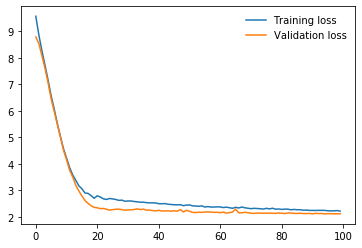

Model for Fold: 2
Epoch: 1/100..  Training Loss: 8.080..  Test Loss: 7.724.. 
Epoch: 2/100..  Training Loss: 7.460..  Test Loss: 7.213.. 
Epoch: 3/100..  Training Loss: 6.914..  Test Loss: 6.734.. 
Epoch: 4/100..  Training Loss: 6.384..  Test Loss: 6.236.. 
Epoch: 5/100..  Training Loss: 5.906..  Test Loss: 5.833.. 
Epoch: 6/100..  Training Loss: 5.422..  Test Loss: 5.425.. 
Epoch: 7/100..  Training Loss: 5.054..  Test Loss: 4.904.. 
Epoch: 8/100..  Training Loss: 4.617..  Test Loss: 4.555.. 
Epoch: 9/100..  Training Loss: 4.243..  Test Loss: 4.215.. 
Epoch: 10/100..  Training Loss: 3.921..  Test Loss: 3.831.. 
Epoch: 11/100..  Training Loss: 3.650..  Test Loss: 3.492.. 
Epoch: 12/100..  Training Loss: 3.385..  Test Loss: 3.248.. 
Epoch: 13/100..  Training Loss: 3.192..  Test Loss: 2.966.. 
Epoch: 14/100..  Training Loss: 3.006..  Test Loss: 2.742.. 
Epoch: 15/100..  Training Loss: 2.910..  Test Loss: 2.638.. 
Epoch: 16/100..  Training Loss: 2.775..  Test Loss: 2.490.. 
Epoch: 17/100..

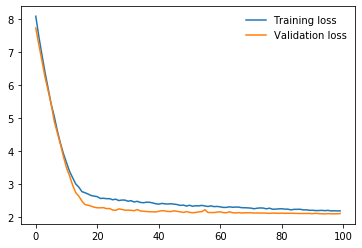

Model for Fold: 3
Epoch: 1/100..  Training Loss: 8.178..  Test Loss: 7.917.. 
Epoch: 2/100..  Training Loss: 7.619..  Test Loss: 7.362.. 
Epoch: 3/100..  Training Loss: 7.080..  Test Loss: 6.972.. 
Epoch: 4/100..  Training Loss: 6.613..  Test Loss: 6.550.. 
Epoch: 5/100..  Training Loss: 6.158..  Test Loss: 6.086.. 
Epoch: 6/100..  Training Loss: 5.691..  Test Loss: 5.673.. 
Epoch: 7/100..  Training Loss: 5.286..  Test Loss: 5.270.. 
Epoch: 8/100..  Training Loss: 4.864..  Test Loss: 4.812.. 
Epoch: 9/100..  Training Loss: 4.517..  Test Loss: 4.415.. 
Epoch: 10/100..  Training Loss: 4.121..  Test Loss: 4.070.. 
Epoch: 11/100..  Training Loss: 3.790..  Test Loss: 3.623.. 
Epoch: 12/100..  Training Loss: 3.471..  Test Loss: 3.385.. 
Epoch: 13/100..  Training Loss: 3.234..  Test Loss: 3.097.. 
Epoch: 14/100..  Training Loss: 3.032..  Test Loss: 2.863.. 
Epoch: 15/100..  Training Loss: 2.956..  Test Loss: 2.708.. 
Epoch: 16/100..  Training Loss: 2.817..  Test Loss: 2.619.. 
Epoch: 17/100..

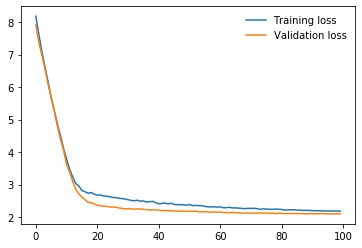

Model for Fold: 4
Epoch: 1/100..  Training Loss: 3.902..  Test Loss: 3.821.. 
Epoch: 2/100..  Training Loss: 3.614..  Test Loss: 3.541.. 
Epoch: 3/100..  Training Loss: 3.468..  Test Loss: 3.216.. 
Epoch: 4/100..  Training Loss: 3.254..  Test Loss: 3.087.. 
Epoch: 5/100..  Training Loss: 3.009..  Test Loss: 2.893.. 
Epoch: 6/100..  Training Loss: 2.828..  Test Loss: 2.715.. 
Epoch: 7/100..  Training Loss: 2.678..  Test Loss: 2.553.. 
Epoch: 8/100..  Training Loss: 2.576..  Test Loss: 2.447.. 
Epoch: 9/100..  Training Loss: 2.518..  Test Loss: 2.382.. 
Epoch: 10/100..  Training Loss: 2.467..  Test Loss: 2.333.. 
Epoch: 11/100..  Training Loss: 2.439..  Test Loss: 2.305.. 
Epoch: 12/100..  Training Loss: 2.408..  Test Loss: 2.266.. 
Epoch: 13/100..  Training Loss: 2.402..  Test Loss: 2.249.. 
Epoch: 14/100..  Training Loss: 2.375..  Test Loss: 2.238.. 
Epoch: 15/100..  Training Loss: 2.359..  Test Loss: 2.228.. 
Epoch: 16/100..  Training Loss: 2.335..  Test Loss: 2.205.. 
Epoch: 17/100..

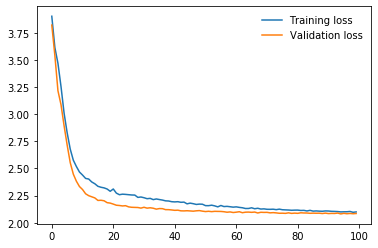

In [23]:
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
cv = cv.split(X_train_scaled, y_train)

m_hidden_layers = 1

n_input = 6
n_hidden = 4
n_output = 1

bs = 64
device = "cuda:0"
epochs = 100

network_type = "regression"

regressors = []

for fold, (train_idx, val_idx) in enumerate(cv):
    print("Model for Fold: " + str(fold))

    train_set, train_labels = X_train_scaled[train_idx], y_train[train_idx]
    valid_set, valid_labels = X_train_scaled[val_idx], y_train[val_idx]
    
    trainset = HousePriceDataset(train_set, train_labels)
    trainloader = DataLoader(trainset, batch_size = bs, shuffle = True)

    validset = HousePriceDataset(valid_set, valid_labels)
    validloader = DataLoader(validset, batch_size = bs, shuffle = True)

    regressor = NeuralNetwork(m_hidden_layers, n_input, n_hidden, n_output, network_type).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(regressor.parameters(), lr=0.001)
    
    train_losses, test_losses = [], []
    for e in range(epochs):
        running_loss = 0

        for features, labels in trainloader:

            regressor.train()

            features = features.to(device)

            labels = labels.to(device)

            optimizer.zero_grad()

            output = regressor(features.float())

            loss = criterion(output, labels.float())

            loss.backward()

            optimizer.step()

            running_loss += loss.item()

        else:
            test_loss = 0

            with torch.no_grad():
                for features, labels in validloader:
                    regressor.eval()

                    features = features.to(device)
                    labels = labels.to(device)

                    output = regressor(features.float())

                    test_loss += criterion(output, labels)


            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(validloader))

            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(validloader)))
        
    plt.plot(train_losses, label='Training loss')
    plt.plot(test_losses, label='Validation loss')
    plt.legend(frameon=False)
    plt.show()
    
    regressors.append(regressor)

# The regression problem 
- As you will see below, my regression model has a tendency to predict values close to the mean (labels are from 0 to 4)
- The reason for that could be that the label distribution for the "Scor" feature is a bimodal distribution, this could represent that my model is uncertain what to predict between (0 or 1) and (3, 4) so for minimizing the loss he chooses the center value, in this case (2)

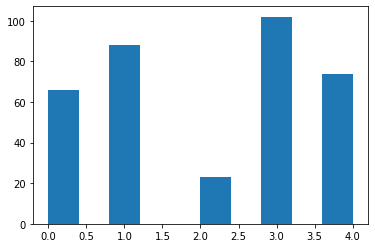

In [24]:
plt.hist(y_test)
plt.show()

In [25]:
evalset = HousePriceDataset(X_test_scaled, y_test)
loader  = DataLoader(evalset, batch_size=len(X_test_scaled))

with torch.no_grad():
    for features, labels in loader: 
        features = features.to(device)
        labels = labels.to(device)
    
        
        outputs = 0
        for regressor in regressors:
            output = regressor(features.float())
            outputs += output
        
        outputs = outputs / len(models)
        
Ypred = outputs.cpu().numpy().squeeze()
Yreal = labels.cpu().numpy()

print("Loss on Testing Data:", criterion(outputs, labels).item())

print("Lets see predictions")
print(Ypred)

optR = OptimizedRounder()

optR.fit(Ypred, Yreal)

coefficients = optR.coefficients()

print("Thresholds:", coefficients)

optimized = optR.predict(Ypred)
rounded   = np.round(Ypred)

print("Regerssion Accuracy with Rounded Values:", accuracy_score(rounded, y_test))
print("Regerssion Accuracy with Optimized Thresholds:", accuracy_score(optimized, y_test))

Loss on Testing Data: 2.1273207664489746
Lets see predictions
[1.9572906 2.0131636 1.9561352 1.9569539 2.0255775 2.0422404 1.9462433
 1.9433167 1.9522823 1.9993387 2.0202413 1.9600004 1.9597759 2.0308492
 1.9736875 2.040694  1.9322666 1.9309467 2.024765  2.0165992 1.9488125
 2.0188253 1.8769009 1.9991906 1.9723225 2.0205634 2.0186431 1.9537085
 1.9377298 1.9561428 1.9718456 1.9698213 2.0235128 1.8961937 2.032653
 2.0222726 1.9524393 2.027067  2.0213337 1.9752455 2.0332685 2.0354342
 1.9496174 1.9353653 2.0233364 1.9990166 2.0393794 2.0378222 1.9100236
 1.9881575 2.0273232 2.0467665 2.0127168 2.0251386 2.0496337 2.006668
 2.0189614 2.0003963 1.9920803 2.03413   2.0182178 2.0138307 1.9578007
 2.0404878 1.9516476 1.9782885 2.0202353 2.0374286 2.003162  1.927589
 1.9441544 2.0360596 1.9949181 1.9955758 2.0197449 2.0440311 2.0023925
 2.0142076 1.9718825 2.0110652 1.9413977 1.936945  2.0468714 1.9500214
 1.9578412 1.9538052 1.8832535 1.9980115 2.006127  1.9889097 1.971925
 1.9904139 2.032399

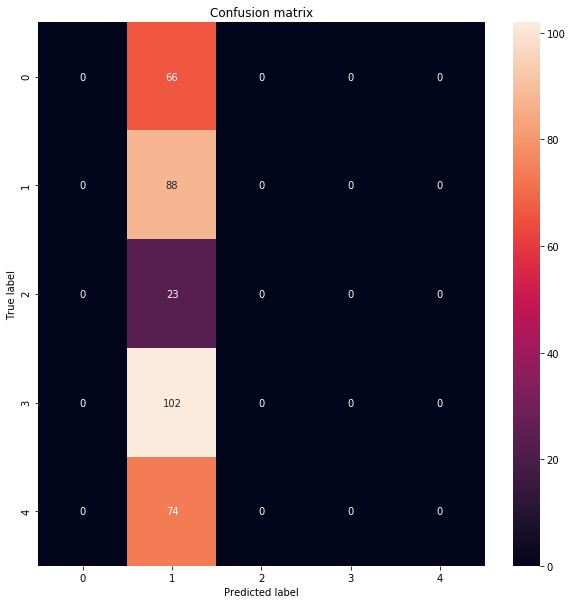

In [26]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, optimized)
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

# Still one more question to ask
- To verify myself, I trained a neural network from Sklearn, which obtains a smaller loss (approx. 0.6) then the pytorch model (approx. 2.1), and the question is "What is different?"
- Both models use Adam as default with the default momentum hyperparameters, with constant learning rate and sam preprocessing methodology, relu activation and batch_size (at the moment of writing this I did not add LeakyReLU, BN or DropOut Regularization)
# And a possible answer:
- The MLPRegressor uses as loss function "squared_errors" with the regularization term that the MSELoss from Pytorch does not use, but I tried to simulate that regularization term by adding weight_decay to the Adam Optimizer... And it showed the same result.. so the question remains... What is different?

https://github.com/scikit-learn/scikit-learn/blob/95d4f0841/sklearn/neural_network/_multilayer_perceptron.py#L1083

Mean Squared Error Neural Network Sklearn:  0.7684701309987394


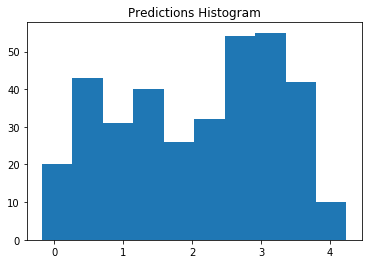

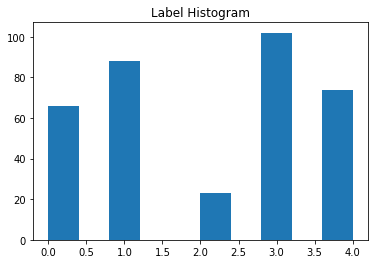

In [27]:
model = MLPRegressor(hidden_layer_sizes = (4), batch_size = 64, max_iter = 100)

model.fit(X_train_scaled, y_train)

y_predict = model.predict(X_test_scaled)

print("Mean Squared Error Neural Network Sklearn: ", mean_squared_error(y_predict, y_test))

plt.hist(y_predict)
plt.title("Predictions Histogram")
plt.show()

plt.hist(y_test)
plt.title("Label Histogram")
plt.show()

# And a simple Linear Regression

In [28]:
regressor = LinearRegression()
regressor.fit(X_train_scaled, y_train)
y_predict = regressor.predict(X_test_scaled)
print("Mean Squared Error Linear Regression Sklearn", mean_squared_error(y_predict, y_test))

Mean Squared Error Linear Regression Sklearn 1.1400216456050454


# And  now a more suitable regression problem for Price
- With Root Mean Square Log Error as loss function

In [29]:
data = pd.read_csv("Bucharest_HousePriceDataset.csv")

display(data.head(n = 10))

features = data.drop(['Pret'], axis = 1, inplace = False)

labels   = data["Pret"]

,Nr Camere,Suprafata,Etaj,Total Etaje,Sector,Scor,Pret
0,4,108.00,2,3,4,5,83000
1,1,41.00,1,8,1,1,39900
2,3,63.52,1,3,2,3,84900
3,1,33.00,3,10,5,1,45500
4,2,62.00,5,9,5,5,54900
5,3,132.00,2,6,1,2,349990
6,2,49.00,6,6,6,4,36500
7,3,92.00,4,8,2,2,119000
8,3,68.00,3,5,4,5,67500
9,3,110.00,1,2,1,1,133000


In [30]:
X_train, X_test, y_train, y_test = train_test_split(features.values, labels.values, train_size = 0.8, random_state = 42)

In [31]:
X_train_scaled, X_test_scaled = preprocessing(X_train, X_test)

# Back to MSE
- I choose to use RMSLE Loss function to to get a better sense of the problem, but in some situations it was not well defined and it returned "nan" as loss value for training and validating steps, so I went back to MSE Loss function

Model for Fold: 0
Epoch: 1/1000..  Training Loss: 13515285284.571..  Test Loss: 12923674624.000.. 
Epoch: 2/1000..  Training Loss: 13402358842.514..  Test Loss: 13014110208.000.. 
Epoch: 3/1000..  Training Loss: 13463888866.743..  Test Loss: 12936766464.000.. 
Epoch: 4/1000..  Training Loss: 13520831122.286..  Test Loss: 12921446400.000.. 
Epoch: 5/1000..  Training Loss: 13438556042.971..  Test Loss: 12834472960.000.. 
Epoch: 6/1000..  Training Loss: 13397687530.057..  Test Loss: 12981255168.000.. 
Epoch: 7/1000..  Training Loss: 13426617929.143..  Test Loss: 12868491264.000.. 
Epoch: 8/1000..  Training Loss: 13363622853.486..  Test Loss: 12862898176.000.. 
Epoch: 9/1000..  Training Loss: 13533633770.057..  Test Loss: 12840486912.000.. 
Epoch: 10/1000..  Training Loss: 13483960202.971..  Test Loss: 12896653312.000.. 
Epoch: 11/1000..  Training Loss: 13705900704.914..  Test Loss: 12744640512.000.. 
Epoch: 12/1000..  Training Loss: 13478868904.229..  Test Loss: 12756696064.000.. 
Epoch: 

Epoch: 101/1000..  Training Loss: 12882639023.543..  Test Loss: 12707293184.000.. 
Epoch: 102/1000..  Training Loss: 12896347896.686..  Test Loss: 12586532864.000.. 
Epoch: 103/1000..  Training Loss: 13085101670.400..  Test Loss: 12598896640.000.. 
Epoch: 104/1000..  Training Loss: 12821063285.029..  Test Loss: 12738316288.000.. 
Epoch: 105/1000..  Training Loss: 12931879058.286..  Test Loss: 12655011840.000.. 
Epoch: 106/1000..  Training Loss: 12854310692.571..  Test Loss: 12722673664.000.. 
Epoch: 107/1000..  Training Loss: 12842741730.743..  Test Loss: 12677559296.000.. 
Epoch: 108/1000..  Training Loss: 12998872385.829..  Test Loss: 12861750272.000.. 
Epoch: 109/1000..  Training Loss: 12936164820.114..  Test Loss: 12579836928.000.. 
Epoch: 110/1000..  Training Loss: 12872943762.286..  Test Loss: 12711038976.000.. 
Epoch: 111/1000..  Training Loss: 12819432916.114..  Test Loss: 12583846912.000.. 
Epoch: 112/1000..  Training Loss: 12951684242.286..  Test Loss: 12656585728.000.. 
Epoc

Epoch: 200/1000..  Training Loss: 11811637569.829..  Test Loss: 12240013312.000.. 
Epoch: 201/1000..  Training Loss: 11934290446.629..  Test Loss: 12410071040.000.. 
Epoch: 202/1000..  Training Loss: 11782398698.057..  Test Loss: 12334196736.000.. 
Epoch: 203/1000..  Training Loss: 11725575138.743..  Test Loss: 12333290496.000.. 
Epoch: 204/1000..  Training Loss: 11868161448.229..  Test Loss: 12290534400.000.. 
Epoch: 205/1000..  Training Loss: 11921485750.857..  Test Loss: 12202082304.000.. 
Epoch: 206/1000..  Training Loss: 11635671054.629..  Test Loss: 12438251520.000.. 
Epoch: 207/1000..  Training Loss: 11707455502.629..  Test Loss: 12274987008.000.. 
Epoch: 208/1000..  Training Loss: 11634680861.257..  Test Loss: 12273696768.000.. 
Epoch: 209/1000..  Training Loss: 11656783506.286..  Test Loss: 12304342016.000.. 
Epoch: 210/1000..  Training Loss: 11756454473.143..  Test Loss: 12360205312.000.. 
Epoch: 211/1000..  Training Loss: 11621896221.257..  Test Loss: 12298094592.000.. 
Epoc

Epoch: 299/1000..  Training Loss: 10358679917.714..  Test Loss: 11610210304.000.. 
Epoch: 300/1000..  Training Loss: 10334333015.771..  Test Loss: 11867512832.000.. 
Epoch: 301/1000..  Training Loss: 10287826900.114..  Test Loss: 11601643520.000.. 
Epoch: 302/1000..  Training Loss: 10317946177.829..  Test Loss: 11552724992.000.. 
Epoch: 303/1000..  Training Loss: 10274681826.743..  Test Loss: 11643977728.000.. 
Epoch: 304/1000..  Training Loss: 10260163935.086..  Test Loss: 11535318016.000.. 
Epoch: 305/1000..  Training Loss: 10368131744.914..  Test Loss: 11587288064.000.. 
Epoch: 306/1000..  Training Loss: 10216752318.171..  Test Loss: 11201914880.000.. 
Epoch: 307/1000..  Training Loss: 10253467925.943..  Test Loss: 11569544192.000.. 
Epoch: 308/1000..  Training Loss: 10402172840.229..  Test Loss: 11428291584.000.. 
Epoch: 309/1000..  Training Loss: 10222834805.029..  Test Loss: 11497774080.000.. 
Epoch: 310/1000..  Training Loss: 10274728725.943..  Test Loss: 11268389888.000.. 
Epoc

Epoch: 400/1000..  Training Loss: 8880372180.114..  Test Loss: 10098648064.000.. 
Epoch: 401/1000..  Training Loss: 8902987556.571..  Test Loss: 10180942848.000.. 
Epoch: 402/1000..  Training Loss: 8790363340.800..  Test Loss: 10106909696.000.. 
Epoch: 403/1000..  Training Loss: 8791151835.429..  Test Loss: 10392285184.000.. 
Epoch: 404/1000..  Training Loss: 8751960780.800..  Test Loss: 10390005760.000.. 
Epoch: 405/1000..  Training Loss: 8674922027.886..  Test Loss: 10372085760.000.. 
Epoch: 406/1000..  Training Loss: 8668903336.229..  Test Loss: 10191518720.000.. 
Epoch: 407/1000..  Training Loss: 8712731428.571..  Test Loss: 10028547072.000.. 
Epoch: 408/1000..  Training Loss: 8619525661.257..  Test Loss: 10198441984.000.. 
Epoch: 409/1000..  Training Loss: 8778095030.857..  Test Loss: 10218131456.000.. 
Epoch: 410/1000..  Training Loss: 8702441018.514..  Test Loss: 9937532928.000.. 
Epoch: 411/1000..  Training Loss: 8721342712.686..  Test Loss: 9932457984.000.. 
Epoch: 412/1000.. 

Epoch: 502/1000..  Training Loss: 7300244333.714..  Test Loss: 8787844096.000.. 
Epoch: 503/1000..  Training Loss: 7269609325.714..  Test Loss: 8943645696.000.. 
Epoch: 504/1000..  Training Loss: 7464929258.057..  Test Loss: 8945576960.000.. 
Epoch: 505/1000..  Training Loss: 7258892814.629..  Test Loss: 8814935040.000.. 
Epoch: 506/1000..  Training Loss: 7275249810.286..  Test Loss: 8796396544.000.. 
Epoch: 507/1000..  Training Loss: 7350756498.286..  Test Loss: 8749225984.000.. 
Epoch: 508/1000..  Training Loss: 7288555351.771..  Test Loss: 9005579264.000.. 
Epoch: 509/1000..  Training Loss: 7209154121.143..  Test Loss: 8901658624.000.. 
Epoch: 510/1000..  Training Loss: 7164030522.514..  Test Loss: 8762915840.000.. 
Epoch: 511/1000..  Training Loss: 7229908816.457..  Test Loss: 8401226240.000.. 
Epoch: 512/1000..  Training Loss: 7242114113.829..  Test Loss: 8286484992.000.. 
Epoch: 513/1000..  Training Loss: 7214333220.571..  Test Loss: 7796155392.000.. 
Epoch: 514/1000..  Training 

Epoch: 604/1000..  Training Loss: 5844240698.514..  Test Loss: 5615781888.000.. 
Epoch: 605/1000..  Training Loss: 5798152257.829..  Test Loss: 5443348480.000.. 
Epoch: 606/1000..  Training Loss: 5824511882.971..  Test Loss: 5781926400.000.. 
Epoch: 607/1000..  Training Loss: 5746565968.457..  Test Loss: 5573495808.000.. 
Epoch: 608/1000..  Training Loss: 5855962909.257..  Test Loss: 5635715584.000.. 
Epoch: 609/1000..  Training Loss: 5829352418.743..  Test Loss: 5713070080.000.. 
Epoch: 610/1000..  Training Loss: 5779169192.229..  Test Loss: 5507495424.000.. 
Epoch: 611/1000..  Training Loss: 5791545344.000..  Test Loss: 5809550848.000.. 
Epoch: 612/1000..  Training Loss: 5691397405.257..  Test Loss: 5560077824.000.. 
Epoch: 613/1000..  Training Loss: 5688817049.600..  Test Loss: 5559434752.000.. 
Epoch: 614/1000..  Training Loss: 5760521508.571..  Test Loss: 5486863872.000.. 
Epoch: 615/1000..  Training Loss: 5666516523.886..  Test Loss: 5500170240.000.. 
Epoch: 616/1000..  Training 

Epoch: 706/1000..  Training Loss: 5071442636.800..  Test Loss: 4521434112.000.. 
Epoch: 707/1000..  Training Loss: 5044562914.743..  Test Loss: 4627219968.000.. 
Epoch: 708/1000..  Training Loss: 5117788408.686..  Test Loss: 4452464640.000.. 
Epoch: 709/1000..  Training Loss: 4955478915.657..  Test Loss: 4550712832.000.. 
Epoch: 710/1000..  Training Loss: 5077589412.571..  Test Loss: 4580944384.000.. 
Epoch: 711/1000..  Training Loss: 5155296672.914..  Test Loss: 4563168768.000.. 
Epoch: 712/1000..  Training Loss: 5018689312.914..  Test Loss: 4513658368.000.. 
Epoch: 713/1000..  Training Loss: 4954510438.400..  Test Loss: 4465175040.000.. 
Epoch: 714/1000..  Training Loss: 5022741752.686..  Test Loss: 4438442496.000.. 
Epoch: 715/1000..  Training Loss: 5018021112.686..  Test Loss: 4564102144.000.. 
Epoch: 716/1000..  Training Loss: 5032473746.286..  Test Loss: 4404280320.000.. 
Epoch: 717/1000..  Training Loss: 5037022273.829..  Test Loss: 4543516672.000.. 
Epoch: 718/1000..  Training 

Epoch: 808/1000..  Training Loss: 4773277615.543..  Test Loss: 3942930944.000.. 
Epoch: 809/1000..  Training Loss: 4755986373.486..  Test Loss: 3945754624.000.. 
Epoch: 810/1000..  Training Loss: 4820754991.543..  Test Loss: 3846039296.000.. 
Epoch: 811/1000..  Training Loss: 4714496914.286..  Test Loss: 3954073344.000.. 
Epoch: 812/1000..  Training Loss: 4751948712.229..  Test Loss: 3913688320.000.. 
Epoch: 813/1000..  Training Loss: 4745531139.657..  Test Loss: 3858392832.000.. 
Epoch: 814/1000..  Training Loss: 4763979366.400..  Test Loss: 3944147712.000.. 
Epoch: 815/1000..  Training Loss: 4747737530.514..  Test Loss: 3886355200.000.. 
Epoch: 816/1000..  Training Loss: 4784774794.971..  Test Loss: 3934072576.000.. 
Epoch: 817/1000..  Training Loss: 4810649307.429..  Test Loss: 3898252544.000.. 
Epoch: 818/1000..  Training Loss: 4751461412.571..  Test Loss: 3840886528.000.. 
Epoch: 819/1000..  Training Loss: 4747613410.743..  Test Loss: 3846225664.000.. 
Epoch: 820/1000..  Training 

Epoch: 911/1000..  Training Loss: 4669837059.657..  Test Loss: 3704952832.000.. 
Epoch: 912/1000..  Training Loss: 4756435302.400..  Test Loss: 3790771968.000.. 
Epoch: 913/1000..  Training Loss: 4727163940.571..  Test Loss: 3846703616.000.. 
Epoch: 914/1000..  Training Loss: 4668486634.057..  Test Loss: 3755687936.000.. 
Epoch: 915/1000..  Training Loss: 4707720111.543..  Test Loss: 3716934144.000.. 
Epoch: 916/1000..  Training Loss: 4685040036.571..  Test Loss: 3768918016.000.. 
Epoch: 917/1000..  Training Loss: 4673480192.000..  Test Loss: 3715923968.000.. 
Epoch: 918/1000..  Training Loss: 4675092165.486..  Test Loss: 3821533952.000.. 
Epoch: 919/1000..  Training Loss: 4727239204.571..  Test Loss: 3737632512.000.. 
Epoch: 920/1000..  Training Loss: 4681900061.257..  Test Loss: 3870052096.000.. 
Epoch: 921/1000..  Training Loss: 4730419097.600..  Test Loss: 3756740352.000.. 
Epoch: 922/1000..  Training Loss: 4727870840.686..  Test Loss: 3731194624.000.. 
Epoch: 923/1000..  Training 

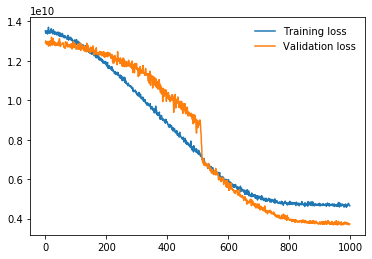

Model for Fold: 1
Epoch: 1/1000..  Training Loss: 13551294976.000..  Test Loss: 12103532544.000.. 
Epoch: 2/1000..  Training Loss: 13630256042.667..  Test Loss: 12177615872.000.. 
Epoch: 3/1000..  Training Loss: 13667639608.889..  Test Loss: 12138308608.000.. 
Epoch: 4/1000..  Training Loss: 13739495793.778..  Test Loss: 12125950976.000.. 
Epoch: 5/1000..  Training Loss: 13547457991.111..  Test Loss: 12032274432.000.. 
Epoch: 6/1000..  Training Loss: 13573363200.000..  Test Loss: 12176612352.000.. 
Epoch: 7/1000..  Training Loss: 13614168576.000..  Test Loss: 12116027392.000.. 
Epoch: 8/1000..  Training Loss: 13630072177.778..  Test Loss: 12178544640.000.. 
Epoch: 9/1000..  Training Loss: 13649168810.667..  Test Loss: 12177377280.000.. 
Epoch: 10/1000..  Training Loss: 13562805333.333..  Test Loss: 12194646016.000.. 
Epoch: 11/1000..  Training Loss: 13572339427.556..  Test Loss: 12134126592.000.. 
Epoch: 12/1000..  Training Loss: 13652739925.333..  Test Loss: 12312712192.000.. 
Epoch: 

Epoch: 102/1000..  Training Loss: 13029666816.000..  Test Loss: 11955723264.000.. 
Epoch: 103/1000..  Training Loss: 13042966044.444..  Test Loss: 11824829440.000.. 
Epoch: 104/1000..  Training Loss: 12988799203.556..  Test Loss: 11753464832.000.. 
Epoch: 105/1000..  Training Loss: 13211366656.000..  Test Loss: 11844481024.000.. 
Epoch: 106/1000..  Training Loss: 13133116430.222..  Test Loss: 11888657408.000.. 
Epoch: 107/1000..  Training Loss: 12943237632.000..  Test Loss: 11901972480.000.. 
Epoch: 108/1000..  Training Loss: 12960786005.333..  Test Loss: 12112748544.000.. 
Epoch: 109/1000..  Training Loss: 13012723854.222..  Test Loss: 11770006528.000.. 
Epoch: 110/1000..  Training Loss: 13014518954.667..  Test Loss: 11814377472.000.. 
Epoch: 111/1000..  Training Loss: 13041468871.111..  Test Loss: 12067850240.000.. 
Epoch: 112/1000..  Training Loss: 12984080568.889..  Test Loss: 11879684096.000.. 
Epoch: 113/1000..  Training Loss: 12993900017.778..  Test Loss: 12068163584.000.. 
Epoc

Epoch: 202/1000..  Training Loss: 11877954958.222..  Test Loss: 11267553280.000.. 
Epoch: 203/1000..  Training Loss: 11869922958.222..  Test Loss: 11406100480.000.. 
Epoch: 204/1000..  Training Loss: 11904685809.778..  Test Loss: 11573318656.000.. 
Epoch: 205/1000..  Training Loss: 11929347740.444..  Test Loss: 11256829952.000.. 
Epoch: 206/1000..  Training Loss: 11788680177.778..  Test Loss: 11419537408.000.. 
Epoch: 207/1000..  Training Loss: 11808388352.000..  Test Loss: 11237274624.000.. 
Epoch: 208/1000..  Training Loss: 11760987847.111..  Test Loss: 11355227136.000.. 
Epoch: 209/1000..  Training Loss: 11778500679.111..  Test Loss: 11554695168.000.. 
Epoch: 210/1000..  Training Loss: 11801678407.111..  Test Loss: 11297942528.000.. 
Epoch: 211/1000..  Training Loss: 11778377685.333..  Test Loss: 11307337728.000.. 
Epoch: 212/1000..  Training Loss: 11785617735.111..  Test Loss: 11341860864.000.. 
Epoch: 213/1000..  Training Loss: 11699544860.444..  Test Loss: 11555997696.000.. 
Epoc

Epoch: 302/1000..  Training Loss: 10405857265.778..  Test Loss: 10904693760.000.. 
Epoch: 303/1000..  Training Loss: 10381649848.889..  Test Loss: 10554187776.000.. 
Epoch: 304/1000..  Training Loss: 10320110805.333..  Test Loss: 10563356672.000.. 
Epoch: 305/1000..  Training Loss: 10319287808.000..  Test Loss: 10535277568.000.. 
Epoch: 306/1000..  Training Loss: 10362334520.889..  Test Loss: 10451918848.000.. 
Epoch: 307/1000..  Training Loss: 10244105130.667..  Test Loss: 10553249792.000.. 
Epoch: 308/1000..  Training Loss: 10293398058.667..  Test Loss: 10662582272.000.. 
Epoch: 309/1000..  Training Loss: 10207770894.222..  Test Loss: 10393010176.000.. 
Epoch: 310/1000..  Training Loss: 10259959239.111..  Test Loss: 10366047232.000.. 
Epoch: 311/1000..  Training Loss: 10237106801.778..  Test Loss: 10787889152.000.. 
Epoch: 312/1000..  Training Loss: 10364991104.000..  Test Loss: 10364192768.000.. 
Epoch: 313/1000..  Training Loss: 10194175772.444..  Test Loss: 10232367104.000.. 
Epoc

Epoch: 404/1000..  Training Loss: 8644546332.444..  Test Loss: 9448628224.000.. 
Epoch: 405/1000..  Training Loss: 8690880967.111..  Test Loss: 9387593728.000.. 
Epoch: 406/1000..  Training Loss: 8750379911.111..  Test Loss: 9254344704.000.. 
Epoch: 407/1000..  Training Loss: 8699914496.000..  Test Loss: 9323811840.000.. 
Epoch: 408/1000..  Training Loss: 8677331726.222..  Test Loss: 9171580928.000.. 
Epoch: 409/1000..  Training Loss: 8559478542.222..  Test Loss: 9632393216.000.. 
Epoch: 410/1000..  Training Loss: 8548868138.667..  Test Loss: 9312138240.000.. 
Epoch: 411/1000..  Training Loss: 8560110023.111..  Test Loss: 9310583808.000.. 
Epoch: 412/1000..  Training Loss: 8566685312.000..  Test Loss: 9280438272.000.. 
Epoch: 413/1000..  Training Loss: 8570963456.000..  Test Loss: 9389470720.000.. 
Epoch: 414/1000..  Training Loss: 8609741226.667..  Test Loss: 9199952896.000.. 
Epoch: 415/1000..  Training Loss: 8605252736.000..  Test Loss: 9186910208.000.. 
Epoch: 416/1000..  Training 

Epoch: 506/1000..  Training Loss: 7022273870.222..  Test Loss: 6530877952.000.. 
Epoch: 507/1000..  Training Loss: 7048702449.778..  Test Loss: 6252819456.000.. 
Epoch: 508/1000..  Training Loss: 6956483975.111..  Test Loss: 6083594752.000.. 
Epoch: 509/1000..  Training Loss: 7009435811.556..  Test Loss: 6246375424.000.. 
Epoch: 510/1000..  Training Loss: 7004996558.222..  Test Loss: 5983418880.000.. 
Epoch: 511/1000..  Training Loss: 6956163377.778..  Test Loss: 6145321472.000.. 
Epoch: 512/1000..  Training Loss: 6934000817.778..  Test Loss: 6134278656.000.. 
Epoch: 513/1000..  Training Loss: 6906001848.889..  Test Loss: 6275005440.000.. 
Epoch: 514/1000..  Training Loss: 6895912775.111..  Test Loss: 6183068672.000.. 
Epoch: 515/1000..  Training Loss: 6802282538.667..  Test Loss: 6321076224.000.. 
Epoch: 516/1000..  Training Loss: 6847343111.111..  Test Loss: 6068106752.000.. 
Epoch: 517/1000..  Training Loss: 6770460295.111..  Test Loss: 6151697920.000.. 
Epoch: 518/1000..  Training 

Epoch: 608/1000..  Training Loss: 5717509717.333..  Test Loss: 4704890880.000.. 
Epoch: 609/1000..  Training Loss: 5710242723.556..  Test Loss: 4705091072.000.. 
Epoch: 610/1000..  Training Loss: 5709689201.778..  Test Loss: 4916590592.000.. 
Epoch: 611/1000..  Training Loss: 5630175160.889..  Test Loss: 4874809344.000.. 
Epoch: 612/1000..  Training Loss: 5722024014.222..  Test Loss: 4587250688.000.. 
Epoch: 613/1000..  Training Loss: 5768781880.889..  Test Loss: 4713391104.000.. 
Epoch: 614/1000..  Training Loss: 5616859121.778..  Test Loss: 4806493696.000.. 
Epoch: 615/1000..  Training Loss: 5667117959.111..  Test Loss: 4682440192.000.. 
Epoch: 616/1000..  Training Loss: 5666619925.333..  Test Loss: 4787541504.000.. 
Epoch: 617/1000..  Training Loss: 5650960629.333..  Test Loss: 4525574656.000.. 
Epoch: 618/1000..  Training Loss: 5698340657.778..  Test Loss: 4696148480.000.. 
Epoch: 619/1000..  Training Loss: 5608010638.222..  Test Loss: 4667311616.000.. 
Epoch: 620/1000..  Training 

Epoch: 710/1000..  Training Loss: 5072406723.556..  Test Loss: 3842903552.000.. 
Epoch: 711/1000..  Training Loss: 5004884213.333..  Test Loss: 3787301376.000.. 
Epoch: 712/1000..  Training Loss: 5021060380.444..  Test Loss: 3953386496.000.. 
Epoch: 713/1000..  Training Loss: 5012202040.889..  Test Loss: 3929473024.000.. 
Epoch: 714/1000..  Training Loss: 4968171221.333..  Test Loss: 3797701632.000.. 
Epoch: 715/1000..  Training Loss: 5092177258.667..  Test Loss: 3787703808.000.. 
Epoch: 716/1000..  Training Loss: 5028251868.444..  Test Loss: 3815292672.000.. 
Epoch: 717/1000..  Training Loss: 5123156785.778..  Test Loss: 3791665920.000.. 
Epoch: 718/1000..  Training Loss: 5014581368.889..  Test Loss: 3784395520.000.. 
Epoch: 719/1000..  Training Loss: 5079707157.333..  Test Loss: 3797652736.000.. 
Epoch: 720/1000..  Training Loss: 5031560028.444..  Test Loss: 3679398656.000.. 
Epoch: 721/1000..  Training Loss: 5048220323.556..  Test Loss: 3718430976.000.. 
Epoch: 722/1000..  Training 

Epoch: 812/1000..  Training Loss: 4804597617.778..  Test Loss: 3368830976.000.. 
Epoch: 813/1000..  Training Loss: 4878268636.444..  Test Loss: 3438535936.000.. 
Epoch: 814/1000..  Training Loss: 4845115420.444..  Test Loss: 3382211840.000.. 
Epoch: 815/1000..  Training Loss: 4853376426.667..  Test Loss: 3388006656.000.. 
Epoch: 816/1000..  Training Loss: 4882573294.222..  Test Loss: 3302276352.000.. 
Epoch: 817/1000..  Training Loss: 4838994496.000..  Test Loss: 3454822144.000.. 
Epoch: 818/1000..  Training Loss: 4806702471.111..  Test Loss: 3303645440.000.. 
Epoch: 819/1000..  Training Loss: 4844200807.111..  Test Loss: 3360320000.000.. 
Epoch: 820/1000..  Training Loss: 4884265991.111..  Test Loss: 3334863104.000.. 
Epoch: 821/1000..  Training Loss: 4846870072.889..  Test Loss: 3455114496.000.. 
Epoch: 822/1000..  Training Loss: 4854331932.444..  Test Loss: 3288896000.000.. 
Epoch: 823/1000..  Training Loss: 4773086435.556..  Test Loss: 3343200256.000.. 
Epoch: 824/1000..  Training 

Epoch: 914/1000..  Training Loss: 4878603768.889..  Test Loss: 3240715776.000.. 
Epoch: 915/1000..  Training Loss: 4791607367.111..  Test Loss: 3262732800.000.. 
Epoch: 916/1000..  Training Loss: 4754203420.444..  Test Loss: 3255596288.000.. 
Epoch: 917/1000..  Training Loss: 4821649912.889..  Test Loss: 3253460224.000.. 
Epoch: 918/1000..  Training Loss: 4795517895.111..  Test Loss: 3221543424.000.. 
Epoch: 919/1000..  Training Loss: 4750387758.222..  Test Loss: 3343812352.000.. 
Epoch: 920/1000..  Training Loss: 4777746759.111..  Test Loss: 3252836864.000.. 
Epoch: 921/1000..  Training Loss: 4735912028.444..  Test Loss: 3304993280.000.. 
Epoch: 922/1000..  Training Loss: 4864227644.444..  Test Loss: 3297136640.000.. 
Epoch: 923/1000..  Training Loss: 4796256760.889..  Test Loss: 3218886400.000.. 
Epoch: 924/1000..  Training Loss: 4816245952.000..  Test Loss: 3218134528.000.. 
Epoch: 925/1000..  Training Loss: 4810691399.111..  Test Loss: 3312549376.000.. 
Epoch: 926/1000..  Training 

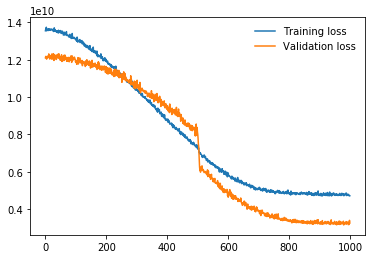

Model for Fold: 2
Epoch: 1/1000..  Training Loss: 12664658519.771..  Test Loss: 17399717888.000.. 
Epoch: 2/1000..  Training Loss: 12675197805.714..  Test Loss: 16764051456.000.. 
Epoch: 3/1000..  Training Loss: 12671662460.343..  Test Loss: 15575094272.000.. 
Epoch: 4/1000..  Training Loss: 12656543100.343..  Test Loss: 15870418944.000.. 
Epoch: 5/1000..  Training Loss: 12652327380.114..  Test Loss: 15383773184.000.. 
Epoch: 6/1000..  Training Loss: 12647389754.514..  Test Loss: 15297803264.000.. 
Epoch: 7/1000..  Training Loss: 12649447745.829..  Test Loss: 16220178432.000.. 
Epoch: 8/1000..  Training Loss: 12670565156.571..  Test Loss: 15771207680.000.. 
Epoch: 9/1000..  Training Loss: 12658631299.657..  Test Loss: 15855490048.000.. 
Epoch: 10/1000..  Training Loss: 12652049115.429..  Test Loss: 18207827968.000.. 
Epoch: 11/1000..  Training Loss: 12654550747.429..  Test Loss: 15154000896.000.. 
Epoch: 12/1000..  Training Loss: 12641167886.629..  Test Loss: 15837113344.000.. 
Epoch: 

Epoch: 101/1000..  Training Loss: 12144637922.743..  Test Loss: 15673976832.000.. 
Epoch: 102/1000..  Training Loss: 12129683251.200..  Test Loss: 15806621696.000.. 
Epoch: 103/1000..  Training Loss: 12119809960.229..  Test Loss: 15307697152.000.. 
Epoch: 104/1000..  Training Loss: 12121697221.486..  Test Loss: 16906387456.000.. 
Epoch: 105/1000..  Training Loss: 12090978830.629..  Test Loss: 15430715392.000.. 
Epoch: 106/1000..  Training Loss: 12091096897.829..  Test Loss: 16192539648.000.. 
Epoch: 107/1000..  Training Loss: 12082334281.143..  Test Loss: 15854187520.000.. 
Epoch: 108/1000..  Training Loss: 12078031637.943..  Test Loss: 16027372544.000.. 
Epoch: 109/1000..  Training Loss: 12058776897.829..  Test Loss: 15082220544.000.. 
Epoch: 110/1000..  Training Loss: 12045380754.286..  Test Loss: 15194491904.000.. 
Epoch: 111/1000..  Training Loss: 12036293529.600..  Test Loss: 15312257024.000.. 
Epoch: 112/1000..  Training Loss: 12029311634.286..  Test Loss: 14853460992.000.. 
Epoc

Epoch: 200/1000..  Training Loss: 11063710837.029..  Test Loss: 14017958912.000.. 
Epoch: 201/1000..  Training Loss: 11026420516.571..  Test Loss: 14557631488.000.. 
Epoch: 202/1000..  Training Loss: 11020178709.943..  Test Loss: 15189490688.000.. 
Epoch: 203/1000..  Training Loss: 10991543325.257..  Test Loss: 14643267584.000.. 
Epoch: 204/1000..  Training Loss: 10991725772.800..  Test Loss: 14465954816.000.. 
Epoch: 205/1000..  Training Loss: 10993656071.314..  Test Loss: 15323840512.000.. 
Epoch: 206/1000..  Training Loss: 10983640766.171..  Test Loss: 14456730624.000.. 
Epoch: 207/1000..  Training Loss: 10945549253.486..  Test Loss: 15089795072.000.. 
Epoch: 208/1000..  Training Loss: 10942486659.657..  Test Loss: 14080960512.000.. 
Epoch: 209/1000..  Training Loss: 10953232179.200..  Test Loss: 14095436800.000.. 
Epoch: 210/1000..  Training Loss: 10915889883.429..  Test Loss: 13700134912.000.. 
Epoch: 211/1000..  Training Loss: 10888067145.143..  Test Loss: 14906490880.000.. 
Epoc

Epoch: 299/1000..  Training Loss: 9649973774.629..  Test Loss: 13495650304.000.. 
Epoch: 300/1000..  Training Loss: 9649177760.914..  Test Loss: 13049416704.000.. 
Epoch: 301/1000..  Training Loss: 9602992010.971..  Test Loss: 12918197248.000.. 
Epoch: 302/1000..  Training Loss: 9575837184.000..  Test Loss: 12480557056.000.. 
Epoch: 303/1000..  Training Loss: 9584052677.486..  Test Loss: 13128984576.000.. 
Epoch: 304/1000..  Training Loss: 9557456340.114..  Test Loss: 12562127872.000.. 
Epoch: 305/1000..  Training Loss: 9574522953.143..  Test Loss: 12955828224.000.. 
Epoch: 306/1000..  Training Loss: 9525215553.829..  Test Loss: 12946080768.000.. 
Epoch: 307/1000..  Training Loss: 9554639754.971..  Test Loss: 13467933696.000.. 
Epoch: 308/1000..  Training Loss: 9543937696.914..  Test Loss: 12390988800.000.. 
Epoch: 309/1000..  Training Loss: 9477357041.371..  Test Loss: 12352455680.000.. 
Epoch: 310/1000..  Training Loss: 9509059481.600..  Test Loss: 13052972032.000.. 
Epoch: 311/1000.

Epoch: 399/1000..  Training Loss: 8091584848.457..  Test Loss: 11369995264.000.. 
Epoch: 400/1000..  Training Loss: 8082742593.829..  Test Loss: 11173090304.000.. 
Epoch: 401/1000..  Training Loss: 8051199517.257..  Test Loss: 12041559040.000.. 
Epoch: 402/1000..  Training Loss: 8007215221.029..  Test Loss: 10789919744.000.. 
Epoch: 403/1000..  Training Loss: 8040846189.714..  Test Loss: 11068902400.000.. 
Epoch: 404/1000..  Training Loss: 8009944656.457..  Test Loss: 11188584448.000.. 
Epoch: 405/1000..  Training Loss: 7984464193.829..  Test Loss: 11314574336.000.. 
Epoch: 406/1000..  Training Loss: 7954978479.543..  Test Loss: 11692235776.000.. 
Epoch: 407/1000..  Training Loss: 7928406337.829..  Test Loss: 10472365056.000.. 
Epoch: 408/1000..  Training Loss: 7916512285.257..  Test Loss: 10646784000.000.. 
Epoch: 409/1000..  Training Loss: 7916201749.943..  Test Loss: 10589010944.000.. 
Epoch: 410/1000..  Training Loss: 7931783767.771..  Test Loss: 10942643200.000.. 
Epoch: 411/1000.

Epoch: 500/1000..  Training Loss: 6552684273.371..  Test Loss: 9628988416.000.. 
Epoch: 501/1000..  Training Loss: 6545777290.971..  Test Loss: 9063138304.000.. 
Epoch: 502/1000..  Training Loss: 6492509527.771..  Test Loss: 9363329024.000.. 
Epoch: 503/1000..  Training Loss: 6498436736.000..  Test Loss: 9961062400.000.. 
Epoch: 504/1000..  Training Loss: 6509383416.686..  Test Loss: 9632073728.000.. 
Epoch: 505/1000..  Training Loss: 6522416237.714..  Test Loss: 10022818816.000.. 
Epoch: 506/1000..  Training Loss: 6487301354.057..  Test Loss: 9515204608.000.. 
Epoch: 507/1000..  Training Loss: 6439285343.086..  Test Loss: 8884210688.000.. 
Epoch: 508/1000..  Training Loss: 6549831292.343..  Test Loss: 8770197504.000.. 
Epoch: 509/1000..  Training Loss: 6467097936.457..  Test Loss: 9163181056.000.. 
Epoch: 510/1000..  Training Loss: 6397468445.257..  Test Loss: 9038213120.000.. 
Epoch: 511/1000..  Training Loss: 6380444423.314..  Test Loss: 8659516416.000.. 
Epoch: 512/1000..  Training

Epoch: 602/1000..  Training Loss: 5259655928.686..  Test Loss: 7329656320.000.. 
Epoch: 603/1000..  Training Loss: 5292507589.486..  Test Loss: 7717046784.000.. 
Epoch: 604/1000..  Training Loss: 5252775445.943..  Test Loss: 7276354048.000.. 
Epoch: 605/1000..  Training Loss: 5202118407.314..  Test Loss: 7506763776.000.. 
Epoch: 606/1000..  Training Loss: 5284808265.143..  Test Loss: 7556924928.000.. 
Epoch: 607/1000..  Training Loss: 5282138155.886..  Test Loss: 8584564224.000.. 
Epoch: 608/1000..  Training Loss: 5186424956.343..  Test Loss: 7369271808.000.. 
Epoch: 609/1000..  Training Loss: 5234209075.200..  Test Loss: 7925458432.000.. 
Epoch: 610/1000..  Training Loss: 5229295776.914..  Test Loss: 7348483584.000.. 
Epoch: 611/1000..  Training Loss: 5210457234.286..  Test Loss: 7295421952.000.. 
Epoch: 612/1000..  Training Loss: 5228183120.457..  Test Loss: 8035743232.000.. 
Epoch: 613/1000..  Training Loss: 5134767879.314..  Test Loss: 7082644480.000.. 
Epoch: 614/1000..  Training 

Epoch: 704/1000..  Training Loss: 4631554940.343..  Test Loss: 6113408512.000.. 
Epoch: 705/1000..  Training Loss: 4551731368.229..  Test Loss: 6052107776.000.. 
Epoch: 706/1000..  Training Loss: 4478268701.257..  Test Loss: 7273640960.000.. 
Epoch: 707/1000..  Training Loss: 4544677090.743..  Test Loss: 6316582912.000.. 
Epoch: 708/1000..  Training Loss: 4519249408.000..  Test Loss: 6163984384.000.. 
Epoch: 709/1000..  Training Loss: 4540028386.743..  Test Loss: 6369879040.000.. 
Epoch: 710/1000..  Training Loss: 4480606153.143..  Test Loss: 6523401728.000.. 
Epoch: 711/1000..  Training Loss: 4583530327.771..  Test Loss: 7534657536.000.. 
Epoch: 712/1000..  Training Loss: 4546568155.429..  Test Loss: 6383946240.000.. 
Epoch: 713/1000..  Training Loss: 4497810278.400..  Test Loss: 6199217152.000.. 
Epoch: 714/1000..  Training Loss: 4513693820.343..  Test Loss: 6384215040.000.. 
Epoch: 715/1000..  Training Loss: 4551272067.657..  Test Loss: 6082624000.000.. 
Epoch: 716/1000..  Training 

Epoch: 806/1000..  Training Loss: 4318010997.029..  Test Loss: 5739379712.000.. 
Epoch: 807/1000..  Training Loss: 4327497216.000..  Test Loss: 5446070784.000.. 
Epoch: 808/1000..  Training Loss: 4295375173.486..  Test Loss: 5334259200.000.. 
Epoch: 809/1000..  Training Loss: 4404195309.714..  Test Loss: 5684583936.000.. 
Epoch: 810/1000..  Training Loss: 4355292145.371..  Test Loss: 5357946880.000.. 
Epoch: 811/1000..  Training Loss: 4295285814.857..  Test Loss: 5496658944.000.. 
Epoch: 812/1000..  Training Loss: 4310810752.000..  Test Loss: 6195332096.000.. 
Epoch: 813/1000..  Training Loss: 4294758743.771..  Test Loss: 5979163136.000.. 
Epoch: 814/1000..  Training Loss: 4311521221.486..  Test Loss: 5687832064.000.. 
Epoch: 815/1000..  Training Loss: 4304114706.286..  Test Loss: 5524188672.000.. 
Epoch: 816/1000..  Training Loss: 4333211794.286..  Test Loss: 5382673920.000.. 
Epoch: 817/1000..  Training Loss: 4402895630.629..  Test Loss: 6558931456.000.. 
Epoch: 818/1000..  Training 

Epoch: 908/1000..  Training Loss: 4290550275.657..  Test Loss: 5812303872.000.. 
Epoch: 909/1000..  Training Loss: 4288680199.314..  Test Loss: 5848798720.000.. 
Epoch: 910/1000..  Training Loss: 4249927475.200..  Test Loss: 5790326784.000.. 
Epoch: 911/1000..  Training Loss: 4282135606.857..  Test Loss: 5182215168.000.. 
Epoch: 912/1000..  Training Loss: 4223788258.743..  Test Loss: 5294424064.000.. 
Epoch: 913/1000..  Training Loss: 4286930556.343..  Test Loss: 5336260096.000.. 
Epoch: 914/1000..  Training Loss: 4268160530.286..  Test Loss: 5533853184.000.. 
Epoch: 915/1000..  Training Loss: 4250349158.400..  Test Loss: 5320288768.000.. 
Epoch: 916/1000..  Training Loss: 4232843428.571..  Test Loss: 5822277120.000.. 
Epoch: 917/1000..  Training Loss: 4304830815.086..  Test Loss: 5399414272.000.. 
Epoch: 918/1000..  Training Loss: 4244091465.143..  Test Loss: 5367036928.000.. 
Epoch: 919/1000..  Training Loss: 4289254999.771..  Test Loss: 5366156800.000.. 
Epoch: 920/1000..  Training 

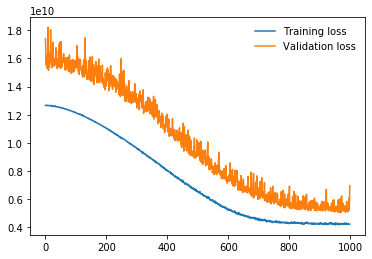

Model for Fold: 3
Epoch: 1/1000..  Training Loss: 13474236558.222..  Test Loss: 12749443072.000.. 
Epoch: 2/1000..  Training Loss: 13461758364.444..  Test Loss: 12576148480.000.. 
Epoch: 3/1000..  Training Loss: 13490737920.000..  Test Loss: 12648037376.000.. 
Epoch: 4/1000..  Training Loss: 13451205134.222..  Test Loss: 12803761152.000.. 
Epoch: 5/1000..  Training Loss: 13501619797.333..  Test Loss: 12936232960.000.. 
Epoch: 6/1000..  Training Loss: 13493046869.333..  Test Loss: 12342072320.000.. 
Epoch: 7/1000..  Training Loss: 13512708551.111..  Test Loss: 12681464832.000.. 
Epoch: 8/1000..  Training Loss: 13489480476.444..  Test Loss: 12435846144.000.. 
Epoch: 9/1000..  Training Loss: 13482106254.222..  Test Loss: 12453724160.000.. 
Epoch: 10/1000..  Training Loss: 13469316821.333..  Test Loss: 12333373440.000.. 
Epoch: 11/1000..  Training Loss: 13514596835.556..  Test Loss: 12570022912.000.. 
Epoch: 12/1000..  Training Loss: 13504959488.000..  Test Loss: 12816616448.000.. 
Epoch: 

Epoch: 101/1000..  Training Loss: 12958378439.111..  Test Loss: 12540239872.000.. 
Epoch: 102/1000..  Training Loss: 12959760711.111..  Test Loss: 12385366016.000.. 
Epoch: 103/1000..  Training Loss: 12934973212.444..  Test Loss: 12154688512.000.. 
Epoch: 104/1000..  Training Loss: 12966868152.889..  Test Loss: 12297859072.000.. 
Epoch: 105/1000..  Training Loss: 12924595854.222..  Test Loss: 12581202944.000.. 
Epoch: 106/1000..  Training Loss: 12925008156.444..  Test Loss: 11948170240.000.. 
Epoch: 107/1000..  Training Loss: 12913821354.667..  Test Loss: 12082413568.000.. 
Epoch: 108/1000..  Training Loss: 12911682360.889..  Test Loss: 12273099776.000.. 
Epoch: 109/1000..  Training Loss: 12847929998.222..  Test Loss: 12262392832.000.. 
Epoch: 110/1000..  Training Loss: 12890552035.556..  Test Loss: 12164861952.000.. 
Epoch: 111/1000..  Training Loss: 12846441614.222..  Test Loss: 11958327296.000.. 
Epoch: 112/1000..  Training Loss: 12819071317.333..  Test Loss: 12159357952.000.. 
Epoc

Epoch: 200/1000..  Training Loss: 11765057706.667..  Test Loss: 11476280320.000.. 
Epoch: 201/1000..  Training Loss: 11706731861.333..  Test Loss: 10926009344.000.. 
Epoch: 202/1000..  Training Loss: 11756985528.889..  Test Loss: 11090468864.000.. 
Epoch: 203/1000..  Training Loss: 11710278186.667..  Test Loss: 11554418688.000.. 
Epoch: 204/1000..  Training Loss: 11732714581.333..  Test Loss: 11389022208.000.. 
Epoch: 205/1000..  Training Loss: 11694591573.333..  Test Loss: 10967471104.000.. 
Epoch: 206/1000..  Training Loss: 11714930503.111..  Test Loss: 10982431744.000.. 
Epoch: 207/1000..  Training Loss: 11624705237.333..  Test Loss: 11528818688.000.. 
Epoch: 208/1000..  Training Loss: 11643975466.667..  Test Loss: 11341197312.000.. 
Epoch: 209/1000..  Training Loss: 11576981361.778..  Test Loss: 11058185216.000.. 
Epoch: 210/1000..  Training Loss: 11600444615.111..  Test Loss: 10984858624.000.. 
Epoch: 211/1000..  Training Loss: 11728995228.444..  Test Loss: 11103470592.000.. 
Epoc

Epoch: 299/1000..  Training Loss: 10255199744.000..  Test Loss: 9745847296.000.. 
Epoch: 300/1000..  Training Loss: 10212353934.222..  Test Loss: 9976702976.000.. 
Epoch: 301/1000..  Training Loss: 10219104782.222..  Test Loss: 9681209344.000.. 
Epoch: 302/1000..  Training Loss: 10249066168.889..  Test Loss: 9986415616.000.. 
Epoch: 303/1000..  Training Loss: 10196209777.778..  Test Loss: 9923682304.000.. 
Epoch: 304/1000..  Training Loss: 10154553628.444..  Test Loss: 9746173952.000.. 
Epoch: 305/1000..  Training Loss: 10121774080.000..  Test Loss: 9789445120.000.. 
Epoch: 306/1000..  Training Loss: 10137733404.444..  Test Loss: 10258053120.000.. 
Epoch: 307/1000..  Training Loss: 10088968263.111..  Test Loss: 9950899200.000.. 
Epoch: 308/1000..  Training Loss: 10142641856.000..  Test Loss: 10200817664.000.. 
Epoch: 309/1000..  Training Loss: 10143140565.333..  Test Loss: 9592348672.000.. 
Epoch: 310/1000..  Training Loss: 10060768995.556..  Test Loss: 10062648320.000.. 
Epoch: 311/10

Epoch: 401/1000..  Training Loss: 8545595548.444..  Test Loss: 8353572864.000.. 
Epoch: 402/1000..  Training Loss: 8582400312.889..  Test Loss: 8740480000.000.. 
Epoch: 403/1000..  Training Loss: 8475150378.667..  Test Loss: 8760544256.000.. 
Epoch: 404/1000..  Training Loss: 8437008014.222..  Test Loss: 8421498880.000.. 
Epoch: 405/1000..  Training Loss: 8527381162.667..  Test Loss: 8629873664.000.. 
Epoch: 406/1000..  Training Loss: 8353062428.444..  Test Loss: 8266590208.000.. 
Epoch: 407/1000..  Training Loss: 8420456448.000..  Test Loss: 8432124928.000.. 
Epoch: 408/1000..  Training Loss: 8461257443.556..  Test Loss: 8391659008.000.. 
Epoch: 409/1000..  Training Loss: 8386831957.333..  Test Loss: 8319196160.000.. 
Epoch: 410/1000..  Training Loss: 8320698965.333..  Test Loss: 8138029568.000.. 
Epoch: 411/1000..  Training Loss: 8329546638.222..  Test Loss: 8431124480.000.. 
Epoch: 412/1000..  Training Loss: 8355854968.889..  Test Loss: 8178342912.000.. 
Epoch: 413/1000..  Training 

Epoch: 503/1000..  Training Loss: 6952567765.333..  Test Loss: 6695567872.000.. 
Epoch: 504/1000..  Training Loss: 6876001464.889..  Test Loss: 6733502464.000.. 
Epoch: 505/1000..  Training Loss: 6950455722.667..  Test Loss: 6718778880.000.. 
Epoch: 506/1000..  Training Loss: 6896890865.778..  Test Loss: 6366206464.000.. 
Epoch: 507/1000..  Training Loss: 6844092394.667..  Test Loss: 6444832256.000.. 
Epoch: 508/1000..  Training Loss: 6868726762.667..  Test Loss: 6797456896.000.. 
Epoch: 509/1000..  Training Loss: 6854897237.333..  Test Loss: 6336975360.000.. 
Epoch: 510/1000..  Training Loss: 6837802702.222..  Test Loss: 6894209536.000.. 
Epoch: 511/1000..  Training Loss: 6814603335.111..  Test Loss: 6674995712.000.. 
Epoch: 512/1000..  Training Loss: 6773339207.111..  Test Loss: 6355752960.000.. 
Epoch: 513/1000..  Training Loss: 6789470755.556..  Test Loss: 6712480256.000.. 
Epoch: 514/1000..  Training Loss: 6797392270.222..  Test Loss: 6556295168.000.. 
Epoch: 515/1000..  Training 

Epoch: 605/1000..  Training Loss: 5719470705.778..  Test Loss: 5363268096.000.. 
Epoch: 606/1000..  Training Loss: 5608994837.333..  Test Loss: 5260093952.000.. 
Epoch: 607/1000..  Training Loss: 5657354325.333..  Test Loss: 5200385024.000.. 
Epoch: 608/1000..  Training Loss: 5614946510.222..  Test Loss: 5219707904.000.. 
Epoch: 609/1000..  Training Loss: 5581970517.333..  Test Loss: 5136419328.000.. 
Epoch: 610/1000..  Training Loss: 5673568490.667..  Test Loss: 5062410752.000.. 
Epoch: 611/1000..  Training Loss: 5561777457.778..  Test Loss: 5012302336.000.. 
Epoch: 612/1000..  Training Loss: 5661793479.111..  Test Loss: 4979162624.000.. 
Epoch: 613/1000..  Training Loss: 5618434229.333..  Test Loss: 5144832000.000.. 
Epoch: 614/1000..  Training Loss: 5563588657.778..  Test Loss: 5186964992.000.. 
Epoch: 615/1000..  Training Loss: 5567139214.222..  Test Loss: 5125020160.000.. 
Epoch: 616/1000..  Training Loss: 5551895843.556..  Test Loss: 5118169088.000.. 
Epoch: 617/1000..  Training 

Epoch: 707/1000..  Training Loss: 5033899456.000..  Test Loss: 4090653952.000.. 
Epoch: 708/1000..  Training Loss: 4959220942.222..  Test Loss: 4249375232.000.. 
Epoch: 709/1000..  Training Loss: 4963388295.111..  Test Loss: 4203869184.000.. 
Epoch: 710/1000..  Training Loss: 5041601386.667..  Test Loss: 4064660736.000.. 
Epoch: 711/1000..  Training Loss: 4920237219.556..  Test Loss: 4127341824.000.. 
Epoch: 712/1000..  Training Loss: 4925485137.778..  Test Loss: 4213781760.000.. 
Epoch: 713/1000..  Training Loss: 4984613845.333..  Test Loss: 3960044800.000.. 
Epoch: 714/1000..  Training Loss: 5001908039.111..  Test Loss: 3980054016.000.. 
Epoch: 715/1000..  Training Loss: 4996687139.556..  Test Loss: 4044399616.000.. 
Epoch: 716/1000..  Training Loss: 4936159424.000..  Test Loss: 4141122560.000.. 
Epoch: 717/1000..  Training Loss: 4954689457.778..  Test Loss: 4187817216.000.. 
Epoch: 718/1000..  Training Loss: 4930156280.889..  Test Loss: 4000888576.000.. 
Epoch: 719/1000..  Training 

Epoch: 809/1000..  Training Loss: 4862502791.111..  Test Loss: 3661147136.000.. 
Epoch: 810/1000..  Training Loss: 4796321621.333..  Test Loss: 3501137920.000.. 
Epoch: 811/1000..  Training Loss: 4740222471.111..  Test Loss: 3491334656.000.. 
Epoch: 812/1000..  Training Loss: 4808133909.333..  Test Loss: 3628835840.000.. 
Epoch: 813/1000..  Training Loss: 4758220686.222..  Test Loss: 3587568640.000.. 
Epoch: 814/1000..  Training Loss: 4746874311.111..  Test Loss: 3742659328.000.. 
Epoch: 815/1000..  Training Loss: 4883616334.222..  Test Loss: 3657816832.000.. 
Epoch: 816/1000..  Training Loss: 4805268394.667..  Test Loss: 3488103680.000.. 
Epoch: 817/1000..  Training Loss: 4806374208.000..  Test Loss: 3740113408.000.. 
Epoch: 818/1000..  Training Loss: 4860039271.111..  Test Loss: 3479372288.000.. 
Epoch: 819/1000..  Training Loss: 4831553585.778..  Test Loss: 3652295936.000.. 
Epoch: 820/1000..  Training Loss: 4818070691.556..  Test Loss: 3941021440.000.. 
Epoch: 821/1000..  Training 

Epoch: 911/1000..  Training Loss: 4751213859.556..  Test Loss: 3568628992.000.. 
Epoch: 912/1000..  Training Loss: 4752958865.778..  Test Loss: 3393270528.000.. 
Epoch: 913/1000..  Training Loss: 4697505464.889..  Test Loss: 3793647360.000.. 
Epoch: 914/1000..  Training Loss: 4766334976.000..  Test Loss: 3454821376.000.. 
Epoch: 915/1000..  Training Loss: 4732752903.111..  Test Loss: 3398587648.000.. 
Epoch: 916/1000..  Training Loss: 4751252344.889..  Test Loss: 3429752832.000.. 
Epoch: 917/1000..  Training Loss: 4685026929.778..  Test Loss: 3471502336.000.. 
Epoch: 918/1000..  Training Loss: 4748772472.889..  Test Loss: 3359593472.000.. 
Epoch: 919/1000..  Training Loss: 4732879530.667..  Test Loss: 3542369536.000.. 
Epoch: 920/1000..  Training Loss: 4701858897.778..  Test Loss: 3531248128.000.. 
Epoch: 921/1000..  Training Loss: 4754005066.667..  Test Loss: 3586058240.000.. 
Epoch: 922/1000..  Training Loss: 4722793272.889..  Test Loss: 3521437184.000.. 
Epoch: 923/1000..  Training 

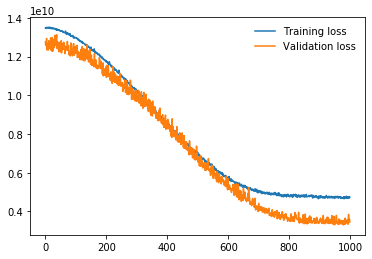

Model for Fold: 4
Epoch: 1/1000..  Training Loss: 13466598257.778..  Test Loss: 12654410752.000.. 
Epoch: 2/1000..  Training Loss: 13465489351.111..  Test Loss: 12608614400.000.. 
Epoch: 3/1000..  Training Loss: 13466094819.556..  Test Loss: 12456009728.000.. 
Epoch: 4/1000..  Training Loss: 13465540465.778..  Test Loss: 13161413632.000.. 
Epoch: 5/1000..  Training Loss: 13463748807.111..  Test Loss: 12140221440.000.. 
Epoch: 6/1000..  Training Loss: 13466013383.111..  Test Loss: 12344993792.000.. 
Epoch: 7/1000..  Training Loss: 13463921351.111..  Test Loss: 12851116032.000.. 
Epoch: 8/1000..  Training Loss: 13462149831.111..  Test Loss: 12538840064.000.. 
Epoch: 9/1000..  Training Loss: 13461074716.444..  Test Loss: 13732706304.000.. 
Epoch: 10/1000..  Training Loss: 13461097941.333..  Test Loss: 13639661568.000.. 
Epoch: 11/1000..  Training Loss: 13459390321.778..  Test Loss: 12647862272.000.. 
Epoch: 12/1000..  Training Loss: 13457011228.444..  Test Loss: 12774110208.000.. 
Epoch: 

Epoch: 101/1000..  Training Loss: 12915008085.333..  Test Loss: 12327785472.000.. 
Epoch: 102/1000..  Training Loss: 12908759196.444..  Test Loss: 12425503744.000.. 
Epoch: 103/1000..  Training Loss: 12899142499.556..  Test Loss: 12366643200.000.. 
Epoch: 104/1000..  Training Loss: 12892143089.778..  Test Loss: 12112603136.000.. 
Epoch: 105/1000..  Training Loss: 12878554624.000..  Test Loss: 13095288832.000.. 
Epoch: 106/1000..  Training Loss: 12860235548.444..  Test Loss: 12060720128.000.. 
Epoch: 107/1000..  Training Loss: 12863554261.333..  Test Loss: 13080422400.000.. 
Epoch: 108/1000..  Training Loss: 12852834190.222..  Test Loss: 13345855488.000.. 
Epoch: 109/1000..  Training Loss: 12837655182.222..  Test Loss: 13282183168.000.. 
Epoch: 110/1000..  Training Loss: 12831744455.111..  Test Loss: 13555233792.000.. 
Epoch: 111/1000..  Training Loss: 12823160263.111..  Test Loss: 13002630144.000.. 
Epoch: 112/1000..  Training Loss: 12815326606.222..  Test Loss: 12816420864.000.. 
Epoc

Epoch: 201/1000..  Training Loss: 11744106211.556..  Test Loss: 11964561408.000.. 
Epoch: 202/1000..  Training Loss: 11716587548.444..  Test Loss: 11200514048.000.. 
Epoch: 203/1000..  Training Loss: 11720963896.889..  Test Loss: 11064403968.000.. 
Epoch: 204/1000..  Training Loss: 11714589084.444..  Test Loss: 11606843392.000.. 
Epoch: 205/1000..  Training Loss: 11667735125.333..  Test Loss: 12397178880.000.. 
Epoch: 206/1000..  Training Loss: 11667754837.333..  Test Loss: 11600717824.000.. 
Epoch: 207/1000..  Training Loss: 11648730282.667..  Test Loss: 11660984320.000.. 
Epoch: 208/1000..  Training Loss: 11645757226.667..  Test Loss: 11539346432.000.. 
Epoch: 209/1000..  Training Loss: 11608616263.111..  Test Loss: 11814170624.000.. 
Epoch: 210/1000..  Training Loss: 11607227662.222..  Test Loss: 11662025728.000.. 
Epoch: 211/1000..  Training Loss: 11574521272.889..  Test Loss: 14035519488.000.. 
Epoch: 212/1000..  Training Loss: 11595553863.111..  Test Loss: 11152956416.000.. 
Epoc

Epoch: 301/1000..  Training Loss: 10239797276.444..  Test Loss: 10837628928.000.. 
Epoch: 302/1000..  Training Loss: 10213041891.556..  Test Loss: 10454379520.000.. 
Epoch: 303/1000..  Training Loss: 10163535118.222..  Test Loss: 13433111552.000.. 
Epoch: 304/1000..  Training Loss: 10173612657.778..  Test Loss: 11451128832.000.. 
Epoch: 305/1000..  Training Loss: 10175194240.000..  Test Loss: 10279050240.000.. 
Epoch: 306/1000..  Training Loss: 10150249144.889..  Test Loss: 10686338048.000.. 
Epoch: 307/1000..  Training Loss: 10094286919.111..  Test Loss: 11118907392.000.. 
Epoch: 308/1000..  Training Loss: 10132879061.333..  Test Loss: 11065910272.000.. 
Epoch: 309/1000..  Training Loss: 10094099626.667..  Test Loss: 10651927552.000.. 
Epoch: 310/1000..  Training Loss: 10102183324.444..  Test Loss: 11208642560.000.. 
Epoch: 311/1000..  Training Loss: 10052980423.111..  Test Loss: 10298621952.000.. 
Epoch: 312/1000..  Training Loss: 10056874453.333..  Test Loss: 10386762752.000.. 
Epoc

Epoch: 401/1000..  Training Loss: 8602632533.333..  Test Loss: 10381854720.000.. 
Epoch: 402/1000..  Training Loss: 8538287004.444..  Test Loss: 8930579456.000.. 
Epoch: 403/1000..  Training Loss: 8499745450.667..  Test Loss: 8998200320.000.. 
Epoch: 404/1000..  Training Loss: 8520320824.889..  Test Loss: 8773865472.000.. 
Epoch: 405/1000..  Training Loss: 8541368135.111..  Test Loss: 8540137472.000.. 
Epoch: 406/1000..  Training Loss: 8477653617.778..  Test Loss: 8301683712.000.. 
Epoch: 407/1000..  Training Loss: 8416057927.111..  Test Loss: 8248131584.000.. 
Epoch: 408/1000..  Training Loss: 8425933724.444..  Test Loss: 8278899712.000.. 
Epoch: 409/1000..  Training Loss: 8456316572.444..  Test Loss: 7837558784.000.. 
Epoch: 410/1000..  Training Loss: 8394845297.778..  Test Loss: 8656449536.000.. 
Epoch: 411/1000..  Training Loss: 8366771200.000..  Test Loss: 7808913920.000.. 
Epoch: 412/1000..  Training Loss: 8364743096.889..  Test Loss: 8063042560.000.. 
Epoch: 413/1000..  Training

Epoch: 503/1000..  Training Loss: 6894603811.556..  Test Loss: 6256835072.000.. 
Epoch: 504/1000..  Training Loss: 6815743992.889..  Test Loss: 6263619584.000.. 
Epoch: 505/1000..  Training Loss: 6835480568.889..  Test Loss: 6992764928.000.. 
Epoch: 506/1000..  Training Loss: 6800456504.889..  Test Loss: 6808314880.000.. 
Epoch: 507/1000..  Training Loss: 6755225564.444..  Test Loss: 7072586240.000.. 
Epoch: 508/1000..  Training Loss: 6735828821.333..  Test Loss: 7481572864.000.. 
Epoch: 509/1000..  Training Loss: 6837954481.778..  Test Loss: 7383402496.000.. 
Epoch: 510/1000..  Training Loss: 6743518798.222..  Test Loss: 7489899008.000.. 
Epoch: 511/1000..  Training Loss: 6711986001.778..  Test Loss: 6457362944.000.. 
Epoch: 512/1000..  Training Loss: 6718705194.667..  Test Loss: 6292445696.000.. 
Epoch: 513/1000..  Training Loss: 6718558115.556..  Test Loss: 7519855616.000.. 
Epoch: 514/1000..  Training Loss: 6721566805.333..  Test Loss: 6918879744.000.. 
Epoch: 515/1000..  Training 

Epoch: 605/1000..  Training Loss: 5571366983.111..  Test Loss: 5233273856.000.. 
Epoch: 606/1000..  Training Loss: 5694629212.444..  Test Loss: 4972545536.000.. 
Epoch: 607/1000..  Training Loss: 5631820103.111..  Test Loss: 4846395904.000.. 
Epoch: 608/1000..  Training Loss: 5514444846.222..  Test Loss: 4929400320.000.. 
Epoch: 609/1000..  Training Loss: 5520405002.667..  Test Loss: 5135711744.000.. 
Epoch: 610/1000..  Training Loss: 5629641905.778..  Test Loss: 4880004608.000.. 
Epoch: 611/1000..  Training Loss: 5550041308.444..  Test Loss: 4732630016.000.. 
Epoch: 612/1000..  Training Loss: 5564513976.889..  Test Loss: 4738108928.000.. 
Epoch: 613/1000..  Training Loss: 5478688974.222..  Test Loss: 5225014272.000.. 
Epoch: 614/1000..  Training Loss: 5549998286.222..  Test Loss: 5001382400.000.. 
Epoch: 615/1000..  Training Loss: 5410617777.778..  Test Loss: 4964465664.000.. 
Epoch: 616/1000..  Training Loss: 5521875832.889..  Test Loss: 5063435264.000.. 
Epoch: 617/1000..  Training 

Epoch: 707/1000..  Training Loss: 4893955143.111..  Test Loss: 4613108224.000.. 
Epoch: 708/1000..  Training Loss: 4864035214.222..  Test Loss: 4005488896.000.. 
Epoch: 709/1000..  Training Loss: 4845178442.667..  Test Loss: 5176556544.000.. 
Epoch: 710/1000..  Training Loss: 4907919587.556..  Test Loss: 4162784512.000.. 
Epoch: 711/1000..  Training Loss: 4911491832.889..  Test Loss: 4305142784.000.. 
Epoch: 712/1000..  Training Loss: 4897846375.111..  Test Loss: 4620808704.000.. 
Epoch: 713/1000..  Training Loss: 4845369038.222..  Test Loss: 4116489984.000.. 
Epoch: 714/1000..  Training Loss: 4829443690.667..  Test Loss: 4012472064.000.. 
Epoch: 715/1000..  Training Loss: 4869288888.889..  Test Loss: 4546700288.000.. 
Epoch: 716/1000..  Training Loss: 4868882119.111..  Test Loss: 5774785024.000.. 
Epoch: 717/1000..  Training Loss: 4882541767.111..  Test Loss: 3890718976.000.. 
Epoch: 718/1000..  Training Loss: 4848467712.000..  Test Loss: 4008094976.000.. 
Epoch: 719/1000..  Training 

Epoch: 809/1000..  Training Loss: 4731605582.222..  Test Loss: 4274844928.000.. 
Epoch: 810/1000..  Training Loss: 4773420017.778..  Test Loss: 3747869440.000.. 
Epoch: 811/1000..  Training Loss: 4693325418.667..  Test Loss: 3781842176.000.. 
Epoch: 812/1000..  Training Loss: 4754666218.667..  Test Loss: 3628795648.000.. 
Epoch: 813/1000..  Training Loss: 4749825809.778..  Test Loss: 4053834496.000.. 
Epoch: 814/1000..  Training Loss: 4732404224.000..  Test Loss: 3684433152.000.. 
Epoch: 815/1000..  Training Loss: 4746497795.556..  Test Loss: 3751494656.000.. 
Epoch: 816/1000..  Training Loss: 4714827239.111..  Test Loss: 3693342464.000.. 
Epoch: 817/1000..  Training Loss: 4680688494.222..  Test Loss: 3538624512.000.. 
Epoch: 818/1000..  Training Loss: 4726017464.889..  Test Loss: 3614222080.000.. 
Epoch: 819/1000..  Training Loss: 4729412387.556..  Test Loss: 4855488000.000.. 
Epoch: 820/1000..  Training Loss: 4748950062.222..  Test Loss: 3938666240.000.. 
Epoch: 821/1000..  Training 

Epoch: 911/1000..  Training Loss: 4647741973.333..  Test Loss: 3529084160.000.. 
Epoch: 912/1000..  Training Loss: 4616042808.889..  Test Loss: 5461155328.000.. 
Epoch: 913/1000..  Training Loss: 4739043740.444..  Test Loss: 3699263744.000.. 
Epoch: 914/1000..  Training Loss: 4680753543.111..  Test Loss: 3537040128.000.. 
Epoch: 915/1000..  Training Loss: 4656114979.556..  Test Loss: 3460975616.000.. 
Epoch: 916/1000..  Training Loss: 4707471729.778..  Test Loss: 4561554432.000.. 
Epoch: 917/1000..  Training Loss: 4702110819.556..  Test Loss: 3497109248.000.. 
Epoch: 918/1000..  Training Loss: 4683558883.556..  Test Loss: 3606550016.000.. 
Epoch: 919/1000..  Training Loss: 4693631800.889..  Test Loss: 3770564352.000.. 
Epoch: 920/1000..  Training Loss: 4701313848.889..  Test Loss: 3860905216.000.. 
Epoch: 921/1000..  Training Loss: 4671454243.556..  Test Loss: 3837485568.000.. 
Epoch: 922/1000..  Training Loss: 4691143971.556..  Test Loss: 3520384000.000.. 
Epoch: 923/1000..  Training 

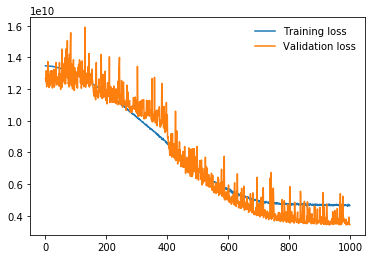

In [32]:
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
cv = cv.split(X_train_scaled, y_train)

m_hidden_layers = 10

n_input = 6
n_hidden = 4
n_output = 1

bs = 64
device = "cuda:0"
epochs = 1000

network_type = "regression"

regressors = []

for fold, (train_idx, val_idx) in enumerate(cv):
    print("Model for Fold: " + str(fold))

    train_set, train_labels = X_train_scaled[train_idx], y_train[train_idx]
    valid_set, valid_labels = X_train_scaled[val_idx], y_train[val_idx]
    
    trainset = HousePriceDataset(train_set, train_labels)
    trainloader = DataLoader(trainset, batch_size = bs, shuffle = True)

    validset = HousePriceDataset(valid_set, valid_labels)
    validloader = DataLoader(validset, batch_size = bs, shuffle = True)

    regressor = NeuralNetwork(m_hidden_layers, n_input, n_hidden, n_output, network_type).to(device)
    criterion = nn.MSELoss()
    criterion_2 = RMSLELoss
    optimizer = optim.Adam(regressor.parameters(), lr = 0.005)
    
    train_losses, test_losses = [], []
    for e in range(epochs):
        running_loss = 0

        for features, labels in trainloader:

            regressor.train()

            features = features.to(device)

            labels = labels.to(device)

            optimizer.zero_grad()

            output = regressor(features.float())

            loss = criterion(output, labels.float())

            loss.backward()

            optimizer.step()

            running_loss += loss.item()

        else:
            test_loss = 0

            with torch.no_grad():
                for features, labels in validloader:
                    regressor.eval()

                    features = features.to(device)
                    labels = labels.to(device)

                    output = regressor(features.float())

                    test_loss += criterion(output, labels)


            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(validloader))

            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(validloader)))
            
        
        
    plt.plot(train_losses, label='Training loss')
    plt.plot(test_losses, label='Validation loss')
    plt.legend(frameon=False)
    plt.show()
    
    regressors.append(regressor)

# Evaluations with other metrics
- RMSLE Loss and R2 Score
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html

Loss on Testing Data: 4448829952.0
Lets see predictions
[88288.77  88289.96  88289.24  88288.305 88288.164 88288.18  88288.62
 88289.27  88288.516 88289.414 88289.14  88288.64  88288.734 88288.89
 88288.64  88289.76  88288.03  88287.945 88287.9   88287.84  88289.266
 88289.54  88288.586 88288.93  88289.5   88287.766 88288.27  88289.516
 88289.34  88289.43  88288.7   88287.56  88289.81  88289.4   88289.33
 88288.46  88289.09  88288.555 88288.95  88289.51  88288.73  88289.625
 88288.695 88288.08  88289.36  88290.12  88290.    88289.75  88288.21
 88288.95  88288.69  88289.945 88288.73  88288.086 88289.836 88288.36
 88287.96  88289.68  88287.586 88288.17  88289.87  88288.78  88289.03
 88288.68  88287.99  88289.27  88289.055 88288.9   88288.87  88289.13
 88289.664 88289.305 88287.8   88289.21  88288.76  88289.81  88289.31
 88287.516 88288.62  88289.54  88289.32  88288.555 88288.52  88288.93
 88289.11  88288.664 88289.56  88289.8   88287.85  88289.29  88288.8
 88288.625 88289.77  88289.58  8

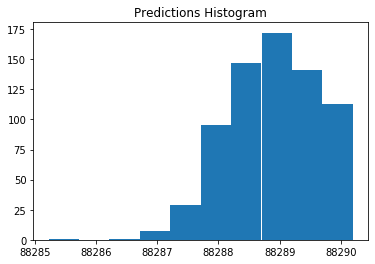

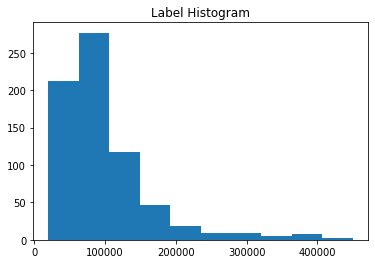

In [48]:
evalset = HousePriceDataset(X_test_scaled, y_test)
loader  = DataLoader(evalset, batch_size=len(X_test_scaled))

with torch.no_grad():
    for features, labels in loader: 
        features = features.to(device)
        labels = labels.to(device)
    
        
        outputs = 0
        for regressor in regressors:
            regressor.eval()
            output = regressor(features.float())
            outputs += output
        
        outputs = outputs / len(models)
        
Ypred = outputs.cpu().numpy().squeeze()
Yreal = labels.cpu().numpy()

print("Loss on Testing Data:", criterion(output, labels).item())

print("Lets see predictions")
print(Ypred)
print(Yreal)

rmsle = RMSLELoss(output, labels)
r2 = r2_score(Yreal, Ypred)

print("R2 Score:", r2)
print("Root Mean Squared Log Error:", rmsle.item())

plt.hist(Ypred)
plt.title("Predictions Histogram")
plt.show()

plt.hist(Yreal)
plt.title("Label Histogram")
plt.show()

# And Sklearn Baseline
# It seems that the problem is still here 
- Even in sklearn if you run multiple runs

Root Mean Squared Log Error Neural Network Sklearn:  0.5421149256846797
R2 Score: -0.0008876584575641111
[97494.1115301 97494.1115301 97494.1115301 97494.1115301 97494.1115301
 97494.1115301 97494.1115301 97494.1115301 97494.1115301 97494.1115301
 97494.1115301 97494.1115301 97494.1115301 97494.1115301 97494.1115301
 97494.1115301 97494.1115301 97494.1115301 97494.1115301 97494.1115301
 97494.1115301 97494.1115301 97494.1115301 97494.1115301 97494.1115301
 97494.1115301 97494.1115301 97494.1115301 97494.1115301 97494.1115301
 97494.1115301 97494.1115301 97494.1115301 97494.1115301 97494.1115301
 97494.1115301 97494.1115301 97494.1115301 97494.1115301 97494.1115301
 97494.1115301 97494.1115301 97494.1115301 97494.1115301 97494.1115301
 97494.1115301 97494.1115301 97494.1115301 97494.1115301 97494.1115301
 97494.1115301 97494.1115301 97494.1115301 97494.1115301 97494.1115301
 97494.1115301 97494.1115301 97494.1115301 97494.1115301 97494.1115301
 97494.1115301 97494.1115301 97494.1115301 

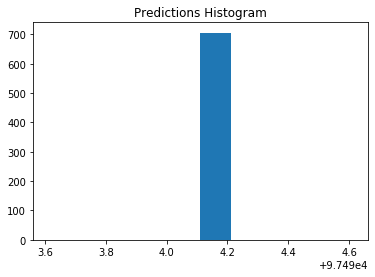

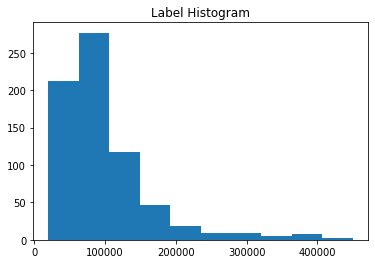

In [49]:
model = MLPRegressor(hidden_layer_sizes = (4, 4, 4, 4, 4, 4, 4, 4, 4), max_iter = 1000)

model.fit(X_train_scaled, y_train)

y_predict = model.predict(X_test_scaled)

print("Root Mean Squared Log Error Neural Network Sklearn: ", RMSLELoss_for_numpy(y_predict, y_test))

r2 = r2_score(y_test, y_predict)
print("R2 Score:", r2)


print(y_predict)

plt.hist(y_predict)
plt.title("Predictions Histogram")
plt.show()

plt.hist(y_test)
plt.title("Label Histogram")
plt.show()

# Ideas for improvements
- Bayesion Optimization for neural network parameters (num_layers, num_neurons, etc.)
- Meta-Models for the regresion part, with stacking or blending methodology
- Other type of date preprocessing and feature extraction